In [1]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display


import sys
sys.path.append("..") # Adds higher directory to python modules path.

import branchingdnn as branching
from branchingdnn import core
from branchingdnn.utils import * 
from branchingdnn.profiler import model_profiler as profiler
from branchingdnn.dataset import prepare
from branchingdnn.branches import branch

# from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# print(y_train)
K= 10 # number of classes

train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

In [3]:
validation_size = 5000
shuffle_size = 22500
batch_size=32
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label,input_size=(227,227), channel_first = False):
            # Normalize images to have a mean of 0 and standard deviation of 1
            # image = tf.image.per_image_standardization(image)
            # Resize images from 32x32 to 277x277
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            
            return image, label

train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))


train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



trainSize 45000
testSize 10000


In [16]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
    
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    
    
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    
    
    def mse_loss(labels, outputs): 
        
        evidence = softplus_evidence(outputs)
        # with sess.as_default():
#         tf.print("evid_relu",evidence)
        alpha = evidence + 1
        # tf.print("alpha",alpha)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
#         print("m",m)
#         print("global", labels)
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
#         C = keras_kl(labels, alpha)
        return (A + B) + C
    
    def mse_loss_global(labels, outputs): 
#         labels = tf.one_hot(tf.cast(labels, tf.int32), 10)
# #         print("onehot",labels)
#         labels = tf.cast(labels, dtype=tf.float32)
#         try:
#             labels= tf.squeeze(labels,[1])
#         except:
#                 print("loss labels can't be squeezed")
        print("global Loss")
        evidence = relu_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
#         print("m",m)
#         print("global", labels)
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
#         C = keras_kl(labels, alpha)
        return (A + B) + C

    if global_loss == True:
        return  mse_loss_global
    else:
        return  mse_loss





In [17]:
class EvidenceEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EvidenceEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = loss_function()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
#             
                
            outputs = tf.matmul(inputs,self.kernel)
#             print(outputs)
            softmax = tf.nn.softmax(outputs)
#             print(softmax)
            
            evidence = self.evidence(outputs)

            alpha = evidence + 1

            loss = tf.reduce_mean(self.loss_fn(labels, outputs))
            
            # labels = tf.cast(tf.one_hot(tf.cast(labels, tf.int32), 10), dtype=labels.dtype)
            # try:
            #     labels= tf.squeeze(labels,[1])
            # except:
            #     print("labels can't be squeezed")
#             print("after labels",labels)
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
            prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            l2_loss = tf.nn.l2_loss(self.weights) * self.lmb
            total_loss = loss + l2_loss
            self.add_loss(total_loss)
            pred = tf.argmax(outputs,1)
# #             print("pred", pred)
#             results = tf.one_hot(pred,self.num_outputs)
            truth = tf.argmax(labels,1)
# #             print("truth", truth)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
# #             print("match", match)
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_avg = tf.reduce_mean(total_evidence)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )

            
            self.add_metric(evidence, name=self.name+"_evidence")
            self.add_metric(u, name=self.name+"_uncertainty")
            self.add_metric(alpha, name = "outputs")
            
            # self.add_metric( , name = "evidence_relu")
            # self.add_metric(mean_avg, name=self.name+"_mean_ev_avg")
            # self.add_metric(mean_succ, name=self.name+"_mean_ev_succ")
            # self.add_metric(mean_fail, name=self.name+"_mean_ev_fail")
            
            
#             total_loss =tf.reduce_mean(normal_loss) + l2_loss
            # print(total_loss)
#             total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
            # print(total_evidence)
#             pred = tf.argmax(outputs, 1)
#             truth = tf.argmax(labels, 1)
#             match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
#             # print("match",match)
#             
#             # print("mean_Avg")


            # print('metrics')
#             self.add_loss(total_loss)
            # print("pred",inputs)
            # print("loss")
     
            
            return softmax
    

In [18]:
class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, annealing_point, verbose=1, **kwargs):
        #annealing_point is the point when the annealing temperature is at max. this is given as a value in terms of batches.
        #at the start of X batches, the temperature will be at max
        #temperature is checked at the start of each batch
        
        self.annealing_point = annealing_point
        self.step_counter = 0
        self.verbose = verbose
        return None
    def on_train_begin(self, logs=None):
        #initialize the annealing at training start 
        
        ### if the annealing_point is 0, then start the full temperature immediately (1).
        if annealing_point == 0:
            self.annealing_rate = 1            
        else:
            self.annealing_rate = 0
        
        self.model.loss = loss_function(self.annealing_point) 
        if self.verbose==2:
            print("Starting training; Loss: {}".format(self.model.loss))
        
    def on_train_batch_begin(self, batch, logs=None):
        self.step_counter = self.step_counter + 1
        self.annealing_rate = tf.minimum(1.0, tf.cast(self.step_counter/self.annealing_point,tf.float32))
        self.model.loss = loss_function(self.annealing_point)
        if self.verbose==2:
            print("...Training: step: {} start of batch {}; annealing_rate = {}".format(self.step_counter, batch, self.annealing_rate))

In [19]:
outputs =[]
targets = keras.Input(shape=(10,),name='targets')
inputs = keras.Input(shape=(227,227,3))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# ### first branch
# branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# branchLayer = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)

x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(10, activation='softmax')(x)
# ### second Branch
# branchLayer2 = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer2 = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer2)

# x = 
x = EvidenceEndpoint(10, activation='relu')(x,targets)

# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = keras.Model(inputs=[inputs,targets], outputs=[x], name="alexnet")
loss_fn = loss_function(1,global_loss=True)
model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
model.summary()


Model: "alexnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 55, 55, 96)   34944       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 55, 55, 96)   384         conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 27, 27, 96)   0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [8]:
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# checkpoint = keras.callbacks.ModelCheckpoint("alexNetv6_evidence_2.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto',period=1)
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# model.fit(train_ds,
#         epochs=10,
#         validation_data=validation_ds,
#         validation_freq=1,
#         # batch_size=1,
#         verbose=1,
#         callbacks=[tensorboard_cb,checkpoint])


Results From training with loss function used in final layer. <br>
1406/1406 - 86s - loss: 2.7580 - accuracy: 0.2376 - evidence_endpoint_8_evidence: 0.0022 - evidence_endpoint_8_uncertainty: 0.9986 - evidence_endpoint_8_mean_ev_avg: 0.0221 - evidence_endpoint_8_mean_ev_succ: 0.0211 - evidence_endpoint_8_mean_ev_fail: 0.0209 <br>
WARNING:tensorflow:Can save best model only with val_loss available, skipping. <br>
Epoch 2/10 <br>
1406/1406 - 84s - loss: 2.7268 - accuracy: 0.3531 - evidence_endpoint_8_evidence: 0.0076 - evidence_endpoint_8_uncertainty: 0.9931 - evidence_endpoint_8_mean_ev_avg: 0.0756 - evidence_endpoint_8_mean_ev_succ: 0.1310 - evidence_endpoint_8_mean_ev_fail: 0.0443 <br>
WARNING:tensorflow:Can save best model only with val_loss available, skipping. <br>
Epoch 3/10 <br>
1406/1406 - 84s - loss: 2.7021 - accuracy: 0.4122 - evidence_endpoint_8_evidence: 0.0255 - evidence_endpoint_8_uncertainty: 0.9784 - evidence_endpoint_8_mean_ev_avg: 0.2545 - evidence_endpoint_8_mean_ev_succ: 0.4588 - evidence_endpoint_8_mean_ev_fail: 0.1103 <br>
WARNING:tensorflow:Can save best model only with val_loss available, skipping. <br>
Epoch 4/10 <br>
1406/1406 - 84s - loss: 2.6790 - accuracy: 0.4565 - evidence_endpoint_8_evidence: 0.0452 - evidence_endpoint_8_uncertainty: 0.9652 - evidence_endpoint_8_mean_ev_avg: 0.4518 - evidence_endpoint_8_mean_ev_succ: 0.8197 - evidence_endpoint_8_mean_ev_fail: 0.1433 <br>
WARNING:tensorflow:Can save best model only with val_loss available, skipping. <br>
Epoch 5/10 <br>

In [9]:
# # print(history)
# test_scores = model.evaluate(test_ds, verbose=2)
# print("overall loss: {}".format(test_scores[0]))

In [15]:
num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
predictions = []
labels = []
iterator = iter(test_ds)
print(len(test_ds))
item = iterator.get_next()
#     print(item)

pClass = []
predictions=[]
pEvidence = []
pUncertainty=[]
pAcc=[]
# for i in range(len(test_ds)-1):
for i in range(10000):
    print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
    item = iterator.get_next()
#         prediction = model.predict(item[0])
    x = model.test_on_batch(item[0],item[1])
    if (x[1]== 1.0):
        print("accuracy:", x[1], "evidence:",x[2])
    pClass.append(tf.argmax(item[1],1).numpy()[0])
    pEvidence.append(x[2])
    pAcc.append(x[1])       
    pUncertainty.append(x[3]) 

10000
evid_relu [[5.88338089 0 0 ... 0 0 9.88089]]
evid_relu [[4.47857428 0 0 ... 0 0 7.76109743]]
evid_relu [[5.09328222 0 0 ... 0 0 7.94621563]]
evid_relu [[4.10114527 0 0 ... 0 0 5.84693]]
evid_relu [[2.6126 0 0 ... 0 0 6.06877136]]
evid_relu [[5.01345205 0 0 ... 0 0 9.61140823]]
evid_relu [[0 0 0 ... 0 0 3.20758867]]
evid_relu [[5.01326036 0 0 ... 0 0 7.11633301]]
evid_relu [[5.84031582 0 0 ... 0 0 10.7376366]]
evid_relu [[4.10894489 0.194758177 0 ... 0 0 8.0266037]]
evid_relu [[2.04543495 0 0 ... 0 0 9.12733555]]
evid_relu [[5.2099824 0 0 ... 0 0 7.20266485]]
evid_relu [[3.30811739 0.517801404 0 ... 0 0.631370306 7.59704876]]
evid_relu [[2.26560354 0 0 ... 0 0 7.71069622]]
evid_relu [[4.82445335 0 0 ... 0 0 10.34622]]
evid_relu [[0 0 0 ... 0 0 7.27460337]]
evid_relu [[3.36203384 0 0 ... 0 0 9.51122761]]
evid_relu [[4.07465649 0 0 ... 0 0 8.83394909]]
evid_relu [[3.45455027 0 0 ... 0 0 7.09834051]]
evid_relu [[2.35707283 0 0 ... 0 0.491787851 9.3849287]]
evid_relu [[3.35544705 0 0 

evid_relu [[3.44741726 0 0 ... 0 0 7.53117085]]
evid_relu [[2.8258996 0 0 ... 0 0 11.1837196]]
evid_relu [[2.69196653 1.29735267 0 ... 0 0.0724672228 6.87343597]]
evid_relu [[3.17997026 0 0 ... 0 0 9.67669]]
evid_relu [[3.76140499 0 0 ... 0 0 7.85425282]]
evid_relu [[4.0653491 0 0 ... 0 0 8.35869694]]
evid_relu [[3.0066092 0 0 ... 0 0.238992959 10.1315937]]
evid_relu [[4.97933531 0 0 ... 0 0 8.74858475]]
evid_relu [[3.36211395 0 0 ... 0 0 6.35207939]]
accuracy: 1.0 evidence: 3.189333915710449
evid_relu [[2.73022938 0 0 ... 0 0 10.1554]]
evid_relu [[4.00822926 0 0 ... 0 0 9.3265]]
evid_relu [[7.0664382 0 0 ... 0 0.297765285 10.5880909]]
evid_relu [[3.76057792 0 0 ... 0 0 11.5300369]]
evid_relu [[2.43154836 0 0 ... 0 0 6.99500847]]
evid_relu [[3.72337341 0.0204972029 0 ... 0 0 8.80243492]]
evid_relu [[3.18276906 0 0 ... 0 0 11.2332411]]
evid_relu [[1.57680416 0 0 ... 0 0 8.98056602]]
evid_relu [[2.12037802 0 0 ... 0 0 8.06955242]]
evid_relu [[5.70948219 0 0 ... 0 0 7.22162914]]
evid_relu

evid_relu [[3.58306837 0.14834255 0 ... 0 0 7.61723232]]
evid_relu [[2.54177237 0 0 ... 0 0 7.76177692]]
evid_relu [[4.02969933 0 0 ... 0 0.0357210338 6.6735]]
evid_relu [[3.43870592 0 0 ... 0 0.0433766246 6.71950245]]
evid_relu [[1.31996787 0 0 ... 0 0 6.55013]]
evid_relu [[2.52874207 0 0 ... 0 0 5.89649487]]
evid_relu [[4.12674522 0 0 ... 0 0.347065806 5.57233763]]
accuracy: 1.0 evidence: 3.9781079292297363
evid_relu [[3.67750454 0 0 ... 0 0.496637 8.93561459]]
evid_relu [[3.2472837 0 0 ... 0 0 6.47868967]]
evid_relu [[3.6398921 0 0 ... 0 0 8.24877071]]
evid_relu [[2.78018427 0.31874907 0 ... 0 0 6.89432335]]
accuracy: 1.0 evidence: 3.4911301136016846
evid_relu [[3.31319404 0 0 ... 0 0 8.30409145]]
evid_relu [[0.983313441 0 0 ... 0 0 7.93212605]]
evid_relu [[5.65702724 0 0 ... 0 0 8.576437]]
evid_relu [[2.85947323 0 0 ... 0 0 8.5347662]]
evid_relu [[2.54557943 0 0 ... 0 0 5.28410101]]
evid_relu [[1.81306076 0 0 ... 0 0 6.43509102]]
evid_relu [[3.41957092 0 0 ... 0 0.756041825 9.84618

accuracy: 1.0 evidence: 4.490002155303955
evid_relu [[2.77710295 0 0 ... 0 0 10.5000219]]
evid_relu [[5.43803 0 0 ... 0 0 10.1236649]]
evid_relu [[3.34849763 0 0 ... 0 0 7.03748035]]
evid_relu [[1.56639206 0 0 ... 0 1.00491548 6.52187395]]
evid_relu [[2.24526262 0 0 ... 0 0 9.07839489]]
evid_relu [[3.01777077 0 0 ... 0 0 8.17794418]]
evid_relu [[2.33031607 0.0142790079 0 ... 0 0 7.58580637]]
evid_relu [[3.01546407 0 0 ... 0 0 8.34498405]]
evid_relu [[3.16969585 0 0 ... 0 0 5.89746857]]
evid_relu [[3.52472186 0 0 ... 0 0 7.58171892]]
evid_relu [[3.47029257 0 0 ... 0 0 8.13438]]
evid_relu [[1.96797013 0 0 ... 0 0 7.05231]]
evid_relu [[4.62649822 0 0 ... 0 0.561781 8.44243813]]
evid_relu [[3.07291555 0 0 ... 0 0 9.78286171]]
evid_relu [[3.85175037 0 0 ... 0 0 6.06072474]]
evid_relu [[2.87781477 0 0 ... 0 0 6.93179]]
evid_relu [[0.573709667 0 0 ... 0 0 6.32545471]]
evid_relu [[2.82614446 0 0 ... 0 0 9.38887596]]
evid_relu [[3.35856605 0 0 ... 0 0 8.09045696]]
evid_relu [[4.63671446 0 0 ...

evid_relu [[2.69518709 0 0 ... 0 0 9.94589901]]
evid_relu [[4.22002 0 0 ... 0 0 8.15790462]]
evid_relu [[4.19613266 0 0 ... 0 0.0127709508 7.34084415]]
evid_relu [[1.14785969 0 0 ... 0 0 7.19154453]]
evid_relu [[4.04779577 0 0 ... 0 0 8.41732597]]
evid_relu [[0.331917018 0 0 ... 0 0.123349935 6.99341297]]
evid_relu [[4.44657516 0 0 ... 0 0 8.82402611]]
evid_relu [[2.15377951 0 0 ... 0 0 11.6095076]]
accuracy: 1.0 evidence: 4.249953269958496
evid_relu [[1.72463727 0 0 ... 0 0 6.97872305]]
accuracy: 1.0 evidence: 3.0504486560821533
evid_relu [[3.4645896 0 0 ... 0 0 6.40306664]]
accuracy: 1.0 evidence: 3.498992919921875
evid_relu [[1.45478737 0 0 ... 0 0.331323206 4.79367447]]
evid_relu [[2.75843644 0 0 ... 0 0 5.86516666]]
evid_relu [[2.72537446 0 0 ... 0 0.0363213867 5.56968975]]
evid_relu [[4.23901033 0 0 ... 0 0 3.08770037]]
evid_relu [[4.88427877 0 0 ... 0 0 8.3046093]]
evid_relu [[4.17282534 0 0 ... 0 0 6.46564388]]
evid_relu [[2.17129111 0 0 ... 0 0 8.4375248]]
evid_relu [[3.032088

evid_relu [[4.27690792 0 0 ... 0 0 6.81107044]]
evid_relu [[3.51014972 0 0 ... 0 0 7.66415691]]
evid_relu [[3.81132746 0 0 ... 0 0 7.52098083]]
evid_relu [[3.73707652 0 0 ... 0 0 7.89877558]]
evid_relu [[3.0148983 0 0 ... 0 0 8.09313202]]
evid_relu [[1.21388471 0 0 ... 0 0 7.93873453]]
evid_relu [[3.49394393 0 0 ... 0 0 7.42375183]]
evid_relu [[3.79571247 0 0 ... 0 0 9.14679527]]
accuracy: 1.0 evidence: 3.793038845062256
evid_relu [[1.63808978 0 0 ... 0 0 6.89468]]
evid_relu [[4.18813229 0 0 ... 0 0 8.55578899]]
evid_relu [[2.98736668 0 0 ... 0 0 6.74145889]]
evid_relu [[2.31150055 0 0 ... 0 0 7.94591761]]
evid_relu [[3.31156921 0 0 ... 0 0 9.24865341]]
evid_relu [[4.46899509 0 0 ... 0 0 8.87944889]]
evid_relu [[3.39205647 0 0 ... 0 0 7.54700899]]
evid_relu [[3.22523332 0 0 ... 0 0 6.62905693]]
evid_relu [[3.35994506 0 0 ... 0 0 5.29485512]]
accuracy: 1.0 evidence: 3.844587802886963
evid_relu [[2.59188318 0 0 ... 0 0 9.831563]]
evid_relu [[3.54460073 0 0 ... 0 0.151450366 11.2947083]]


evid_relu [[2.29416561 0 0 ... 0 0 9.3323]]
evid_relu [[5.19930172 0 0 ... 0 0 12.069313]]
accuracy: 1.0 evidence: 4.582347869873047
evid_relu [[3.16495705 0 0 ... 0 0 6.71833563]]
evid_relu [[3.15797949 0 0 ... 0 0.0939205661 7.11365318]]
evid_relu [[2.82817149 0 0 ... 0 0.0623018146 5.2257328]]
evid_relu [[2.50097108 0 0 ... 0 0.78241241 6.46227741]]
evid_relu [[1.84010017 0 0 ... 0 0 10.1751032]]
evid_relu [[4.63065815 0 0 ... 0 0 9.80337524]]
evid_relu [[4.39640903 0 0 ... 0 0 7.89391136]]
evid_relu [[4.32837772 0.256950974 0 ... 0 0 11.6686306]]
evid_relu [[3.39663601 0.165530682 0 ... 0 0 8.27097225]]
evid_relu [[5.57389593 0 0 ... 0 0 12.152936]]
evid_relu [[3.49738503 0 0 ... 0 0 10.6605606]]
evid_relu [[4.69764042 0 0 ... 0 0 8.53261089]]
evid_relu [[4.52329636 0 0 ... 0 0 10.4945765]]
evid_relu [[4.92191935 0 0 ... 0 0 9.99574661]]
evid_relu [[2.8608427 0.621927917 0 ... 0 0.0207440555 7.46970749]]
evid_relu [[4.57982683 0 0 ... 0 0 9.70935726]]
evid_relu [[1.85452664 0 0 ...

evid_relu [[2.98247743 0 0 ... 0 0 8.79895592]]
evid_relu [[4.52053356 0 0 ... 0 0 8.54697323]]
evid_relu [[2.30303049 0 0 ... 0 0 6.61666393]]
evid_relu [[2.14490795 0.564339399 0 ... 0 0 7.90515423]]
evid_relu [[3.61541319 0 0 ... 0 0 7.60298872]]
evid_relu [[1.98664808 0 0 ... 0 0.0813330114 3.08864832]]
evid_relu [[2.58326292 0 0 ... 0 0 8.50145531]]
evid_relu [[3.66444325 0 0 ... 0 0 8.272089]]
evid_relu [[3.62908435 0 0 ... 0 0 10.0228939]]
evid_relu [[2.77202201 0 0 ... 0 0 6.27830076]]
evid_relu [[2.78709841 0 0 ... 0 0 8.43091106]]
evid_relu [[2.04301357 0 0 ... 0 0.205555528 12.2088709]]
accuracy: 1.0 evidence: 4.627768039703369
evid_relu [[5.23533821 0 0 ... 0 0 12.0279293]]
evid_relu [[3.67568064 0 0 ... 0 0 7.95197535]]
accuracy: 1.0 evidence: 3.8087356090545654
evid_relu [[2.58879256 0 0 ... 0 0 7.39714861]]
evid_relu [[4.05170822 0 0 ... 0 0 7.72217369]]
evid_relu [[2.93962598 0 0 ... 0 0 7.63682461]]
evid_relu [[1.76446438 0 0 ... 0 0 7.78701353]]
evid_relu [[1.33661246

evid_relu [[1.21744943 0 0 ... 0 0 6.45979786]]
evid_relu [[3.95979691 0 0 ... 0 0 7.68017673]]
evid_relu [[3.21989799 0 0 ... 0 0 7.53713465]]
evid_relu [[2.58739686 0.683418453 0 ... 0 0 7.01403761]]
evid_relu [[2.13088179 0 0 ... 0 0 8.02036]]
accuracy: 1.0 evidence: 4.04083776473999
evid_relu [[2.03165674 0 0 ... 0 0.0671368539 8.02945232]]
evid_relu [[4.5509944 0 0 ... 0 0 6.31308031]]
evid_relu [[3.2947433 0 0 ... 0 0 8.31960297]]
evid_relu [[0.310821474 0.0495889187 0 ... 0 0 8.20807838]]
evid_relu [[4.27103186 0 0 ... 0 0 9.07725906]]
accuracy: 1.0 evidence: 4.891942024230957
evid_relu [[4.75230074 0 0 ... 0 0 9.55814266]]
evid_relu [[3.17733145 0 0 ... 0 0 11.8916845]]
evid_relu [[3.66038656 0 0 ... 0 0 7.41919708]]
evid_relu [[1.01859903 0 0 ... 0 0 9.33778191]]
accuracy: 1.0 evidence: 3.3799400329589844
evid_relu [[2.33180594 0.21801734 0 ... 0 0 10.0891447]]
evid_relu [[3.05004668 0 0 ... 0 0 6.6645422]]
evid_relu [[4.57422733 0 0 ... 0 0 9.40400314]]
evid_relu [[3.81839561

evid_relu [[0.895574808 0 0 ... 0 0 7.48439646]]
accuracy: 1.0 evidence: 2.9678635597229004
evid_relu [[4.64618874 0 0 ... 0 0 8.03383732]]
accuracy: 1.0 evidence: 4.153461933135986
evid_relu [[5.310812 0 0 ... 0 0 7.74835062]]
evid_relu [[4.82003403 0 0 ... 0 0 10.6549797]]
evid_relu [[2.61159182 0 0 ... 0 0 5.91345167]]
accuracy: 1.0 evidence: 3.5373454093933105
evid_relu [[5.87938309 0 0 ... 0 0 10.6665154]]
evid_relu [[4.96123362 0 0 ... 0 0 9.98464394]]
evid_relu [[5.79063129 0 0 ... 0 0 9.28873348]]
evid_relu [[3.95606399 0 0 ... 0 0.291467547 9.32778263]]
evid_relu [[2.0302093 0 0 ... 0 0 6.73038292]]
evid_relu [[4.00370264 0.139151931 0 ... 0 0 7.49586105]]
evid_relu [[2.07703042 0 0 ... 0 0.20042026 8.9625721]]
accuracy: 1.0 evidence: 4.147887229919434
evid_relu [[3.51228952 0 0 ... 0 0 5.83489275]]
accuracy: 1.0 evidence: 3.41577410697937
evid_relu [[2.9072423 0 0 ... 0 0 9.29620838]]
evid_relu [[1.32292986 0 0 ... 0 0 9.23758698]]
evid_relu [[1.62118065 0 0 ... 0 0 6.8518357

evid_relu [[3.52313 0 0 ... 0 0 8.08131504]]
evid_relu [[2.19333887 0 0 ... 0 0.678962648 5.71671724]]
evid_relu [[4.57741213 0 0 ... 0 0 10.2224102]]
evid_relu [[2.12708473 0.535148323 0 ... 0 0 6.98595476]]
evid_relu [[3.52485657 0 0 ... 0 0 8.94529533]]
evid_relu [[4.28533268 0 0 ... 0 0 6.58462095]]
accuracy: 1.0 evidence: 3.421096086502075
evid_relu [[1.60261858 0 0 ... 0 0 8.07574081]]
evid_relu [[4.16331291 0 0 ... 0 0 9.66569519]]
evid_relu [[4.41027069 0 0 ... 0 0 8.34064484]]
evid_relu [[4.01352119 0 0 ... 0 0 10.1401949]]
evid_relu [[6.13017559 0 0 ... 0 0 8.87580109]]
evid_relu [[0.523104072 0.0406986475 0 ... 0 0 2.91683483]]
accuracy: 1.0 evidence: 1.201717495918274
evid_relu [[3.06101203 0 0 ... 0 0.0185539126 10.8174648]]
evid_relu [[2.36708331 1.62873411 0 ... 0 0 8.90688801]]
evid_relu [[2.18975782 0 0 ... 0 0 9.82515907]]
evid_relu [[4.69008255 0 0 ... 0 0.534121275 10.99014]]
accuracy: 1.0 evidence: 4.565308570861816
evid_relu [[2.62105441 0 0 ... 0 0 7.13463736]]
e

evid_relu [[3.01615238 0 0 ... 0 0 9.19086838]]
evid_relu [[3.02758074 0 0 ... 0 0 11.2551212]]
evid_relu [[4.75594234 0 0 ... 0 0 7.11382866]]
evid_relu [[3.45701861 0.427013636 0 ... 0 0.729304433 6.44174]]
accuracy: 1.0 evidence: 3.509990692138672
evid_relu [[3.27324605 0 0 ... 0 0.202174842 7.35902596]]
evid_relu [[2.71254373 0 0 ... 0 0 7.94115591]]
evid_relu [[5.88462687 0 0 ... 0 0 9.14983749]]
evid_relu [[2.61002779 0 0 ... 0 0 6.02061844]]
evid_relu [[3.3812871 0 0 ... 0 0.421673059 6.88443279]]
evid_relu [[0 0.225302041 0 ... 0 0 7.50513601]]
evid_relu [[2.62347651 0 0 ... 0 0 8.65268135]]
evid_relu [[2.1103406 0 0 ... 0 0 6.43514109]]
evid_relu [[2.65827751 0 0 ... 0 0 9.0236]]
evid_relu [[3.65467024 0.633465052 0 ... 0 0 10.7916374]]
evid_relu [[3.03540373 0 0 ... 0 0 7.08089828]]
evid_relu [[2.08093119 0 0 ... 0 1.40764952 8.1654377]]
evid_relu [[2.22279572 0 0 ... 0 0 4.92103481]]
evid_relu [[2.7236855 0 0 ... 0 0 10.1533108]]
evid_relu [[2.93658185 0 0 ... 0 0 5.80190897

evid_relu [[2.56403065 0 0 ... 0 0 8.67795372]]
evid_relu [[3.36825371 0 0 ... 0 0 9.33306885]]
evid_relu [[2.20609617 0 0 ... 0 0 8.92957687]]
evid_relu [[2.90772176 0 0 ... 0 0 11.9736977]]
evid_relu [[2.36574078 0 0 ... 0 0 5.96210337]]
evid_relu [[4.50869465 0 0 ... 0 0 7.33939171]]
accuracy: 1.0 evidence: 4.234356880187988
evid_relu [[3.41589928 0 0 ... 0 0 9.858634]]
evid_relu [[4.31681347 0 0 ... 0 0 11.0599442]]
evid_relu [[4.30196095 0 0 ... 0 0 9.46812725]]
evid_relu [[2.01521111 0.883956313 0 ... 0 0.855730653 5.9360342]]
evid_relu [[1.68436337 0 0 ... 0 0 7.48866367]]
evid_relu [[3.03586912 0 0 ... 0 0 9.98450661]]
accuracy: 1.0 evidence: 4.58758020401001
evid_relu [[5.30107498 0.549951077 0 ... 0 0 7.20454073]]
evid_relu [[3.87060165 0 0 ... 0 0 10.7347412]]
evid_relu [[3.12729526 0 0 ... 0 0 6.12238884]]
evid_relu [[4.72984 0.141274571 0 ... 0 0.619260967 7.66903067]]
evid_relu [[0.501159787 0 0 ... 0 0 3.97065115]]
evid_relu [[2.6583252 0 0 ... 0 0.384888381 12.0784626]]

evid_relu [[6.17066097 0 0 ... 0 0.00949209929 10.3752537]]
evid_relu [[5.74385071 0.676021934 0 ... 0 0 8.15367126]]
evid_relu [[4.55199528 0 0 ... 0 0 8.60267067]]
evid_relu [[3.83736038 0 0 ... 0 0 9.95024872]]
evid_relu [[4.4258976 0 0 ... 0 0 7.66129971]]
evid_relu [[2.13794374 0.244409919 0 ... 0 0 6.52029467]]
evid_relu [[2.26929188 0 0 ... 0 0 7.20749664]]
evid_relu [[1.73091435 0 0 ... 0 0 7.58497143]]
evid_relu [[3.73423696 0 0 ... 0 0 10.3470554]]
evid_relu [[3.05171394 0 0 ... 0 0 6.54300976]]
accuracy: 1.0 evidence: 3.345198392868042
evid_relu [[2.03866291 0 0 ... 0 0 7.55939198]]
evid_relu [[5.16042 0 0 ... 0 0 9.97954273]]
accuracy: 1.0 evidence: 4.21280574798584
evid_relu [[1.88602841 0 0 ... 0 0.0916944593 5.66729546]]
accuracy: 1.0 evidence: 3.1274256706237793
evid_relu [[2.59370661 0 0 ... 0 0 9.13125324]]
evid_relu [[5.99397 0 0 ... 0 0 10.8405724]]
evid_relu [[0.980382 0 0 ... 0 0 5.22498465]]
evid_relu [[3.27972507 0 0 ... 0 0 7.62338352]]
evid_relu [[3.1029048 0 

evid_relu [[4.5920105 0 0 ... 0 0 7.46424961]]
evid_relu [[2.6017766 0 0 ... 0 0 9.75770569]]
evid_relu [[1.71628428 0.688184679 0 ... 0 0.379969418 5.32495451]]
evid_relu [[3.11988091 0 0 ... 0 0 7.42535114]]
evid_relu [[1.80915177 0 0 ... 0 0.302407831 7.24920034]]
evid_relu [[1.83398235 0.0256779194 0 ... 0 0 6.63695]]
evid_relu [[3.94256616 0 0 ... 0 0 6.73802567]]
evid_relu [[2.73418808 0 0 ... 0 0 7.26375914]]
evid_relu [[4.34807301 0 0 ... 0 0 9.38923073]]
accuracy: 1.0 evidence: 3.773930072784424
evid_relu [[1.72636402 0 0 ... 0 0 8.6855526]]
evid_relu [[3.64752698 0.703701437 0 ... 0 0 9.56878471]]
evid_relu [[2.57071567 0 0 ... 0 0 6.84537125]]
evid_relu [[3.31508231 0 0 ... 0 0.27186054 7.39019823]]
evid_relu [[3.72903872 0 0 ... 0 0 7.48684311]]
evid_relu [[4.74806261 0 0 ... 0 0 9.45079899]]
evid_relu [[2.38873 0 0 ... 0 0 6.91290855]]
evid_relu [[4.19634247 0 0 ... 0 0 7.52057076]]
evid_relu [[2.65533137 0 0 ... 0 0 4.23086]]
accuracy: 1.0 evidence: 2.397254705429077
evid

evid_relu [[1.8881526 0 0 ... 0 0 4.30311584]]
evid_relu [[3.18045568 0.990285039 0 ... 0 0 7.97596359]]
evid_relu [[5.08938742 0 0 ... 0 0 7.2453537]]
evid_relu [[6.17946053 0 0 ... 0 0 11.0501213]]
evid_relu [[2.1722002 0 0 ... 0 0 6.1118536]]
accuracy: 1.0 evidence: 2.9071044921875
evid_relu [[4.17864513 0 0 ... 0 0 9.63620377]]
evid_relu [[3.86146975 0 0 ... 0 0 7.23219395]]
evid_relu [[5.26769352 0 0 ... 0 0 8.5952549]]
evid_relu [[1.51966667 0 0 ... 0 0 7.19369507]]
accuracy: 1.0 evidence: 3.400151014328003
evid_relu [[2.90056229 0.687888801 0 ... 0 2.00083232 6.50335503]]
evid_relu [[3.59865332 0 0 ... 0 0 12.9082556]]
evid_relu [[2.78271627 0 0 ... 0 0 4.89541626]]
evid_relu [[1.7971344 0 0 ... 0 0.890777767 7.58677483]]
evid_relu [[3.66780591 0 0 ... 0 0 4.4134717]]
evid_relu [[5.11437654 0 0 ... 0 0 7.99165058]]
evid_relu [[4.73925972 0 0 ... 0 0 7.59872913]]
evid_relu [[1.61171281 0 0 ... 0 0 5.18976784]]
evid_relu [[5.3187561 0 0 ... 0 0 7.67572975]]
evid_relu [[4.0661974 0

evid_relu [[1.96966708 0 0 ... 0 0 5.81697369]]
evid_relu [[2.28605294 0.00933647156 0 ... 0 0 6.87440729]]
evid_relu [[3.73997188 0.152841926 0 ... 0 0 8.28512478]]
evid_relu [[4.54034233 0 0 ... 0 0 10.163867]]
evid_relu [[2.03385162 0 0 ... 0 0 7.99372387]]
evid_relu [[5.42493153 0 0 ... 0 0 8.53097343]]
evid_relu [[1.30139256 0.10574317 0 ... 0 0 8.87722206]]
evid_relu [[4.11634064 0 0 ... 0 0 14.2486429]]
evid_relu [[2.71428537 0 0 ... 0 0 5.73896742]]
evid_relu [[4.83047771 0 0 ... 0 0 9.2666111]]
evid_relu [[1.05143964 0 0 ... 0 0 9.55702114]]
evid_relu [[2.0458231 0 0 ... 0 0 7.89982653]]
evid_relu [[3.6651051 0 0 ... 0 0 8.72476578]]
evid_relu [[2.42193699 0 0 ... 0 0 6.25542164]]
evid_relu [[4.08416 0 0 ... 0 0 8.4455986]]
evid_relu [[6.53762293 0 0 ... 0 0.23268041 10.9607668]]
evid_relu [[3.17873764 0 0 ... 0 0 7.52768612]]
accuracy: 1.0 evidence: 3.7362446784973145
evid_relu [[2.07492757 0 0 ... 0 0 7.53364229]]
evid_relu [[5.60434771 0 0 ... 0 0 8.93293285]]
evid_relu [[2

evid_relu [[3.22720671 0 0 ... 0 0 6.80746651]]
accuracy: 1.0 evidence: 3.5927767753601074
evid_relu [[2.70193172 0.489964604 0 ... 0 0 7.96222973]]
evid_relu [[4.86484623 0 0 ... 0 0 10.217082]]
evid_relu [[3.14789033 0 0 ... 0 0 8.92482758]]
evid_relu [[4.4002552 0 0 ... 0 0 12.1710825]]
accuracy: 1.0 evidence: 5.458677291870117
evid_relu [[3.42650175 0 0 ... 0 0 6.43166828]]
evid_relu [[3.8406148 0 0 ... 0 0.262950689 7.51832819]]
evid_relu [[4.4922 0 0 ... 0 0 9.72572517]]
evid_relu [[2.15028143 0 0 ... 0 0 6.74869585]]
evid_relu [[3.60230589 0 0 ... 0 0 8.88520527]]
evid_relu [[2.17745447 0 0 ... 0 0 10.1416292]]
evid_relu [[1.35391855 0 0 ... 0 0 5.71757698]]
accuracy: 1.0 evidence: 2.626676321029663
evid_relu [[3.30184078 0.199985445 0 ... 0 0 6.48681641]]
evid_relu [[2.31929612 0 0 ... 0 0 7.44137287]]
evid_relu [[2.76433635 0 0 ... 0 0 5.64848042]]
evid_relu [[3.1895144 0 0 ... 0 0 5.49320364]]
evid_relu [[0 0.659647465 0 ... 0 0 8.61704254]]
evid_relu [[5.46444893 0 0 ... 0 0

evid_relu [[4.1784749 0 0 ... 0 0 7.00353241]]
evid_relu [[0.533335507 0 0 ... 0 0.204052806 11.6810398]]
evid_relu [[1.67879534 0 0 ... 0 0 6.86998558]]
evid_relu [[4.94508553 0 0 ... 0 0 8.55472946]]
evid_relu [[5.20058298 0 0 ... 0 0.686817408 9.11710548]]
evid_relu [[3.55674052 0 0 ... 0 0 9.14075947]]
evid_relu [[2.58953118 0.423427939 0 ... 0 0 8.60318089]]
evid_relu [[2.66535115 0.201863945 0 ... 0 0 8.87177]]
evid_relu [[2.9817946 0 0 ... 0 0 7.06220245]]
evid_relu [[4.65609074 0.275041878 0 ... 0 0 8.64113]]
evid_relu [[4.34476709 1.31444609 0 ... 0 0 7.35839272]]
evid_relu [[5.88426971 0 0.895130634 ... 0 0 10.0375137]]
evid_relu [[4.18989658 0 0 ... 0 0 7.15759325]]
evid_relu [[1.99757242 0.890556335 0 ... 0 0 6.6744442]]
evid_relu [[4.51421309 0 0 ... 0 0 6.57549381]]
evid_relu [[3.98812079 0 0 ... 0 0 7.91950798]]
evid_relu [[3.66695905 0 0 ... 0 0 6.59808]]
evid_relu [[0.211869538 0 0 ... 0 0 4.55156231]]
evid_relu [[4.13803577 0 0 ... 0 0 10.3215256]]
accuracy: 1.0 evide

evid_relu [[3.19516301 0 0 ... 0 0 8.32764]]
evid_relu [[3.02789307 0 0 ... 0 0 5.79039145]]
evid_relu [[4.42725897 0 0 ... 0 0 9.78785133]]
evid_relu [[3.19766951 0 0 ... 0 0 6.43958902]]
evid_relu [[5.36379194 0 0 ... 0 0 9.73528099]]
evid_relu [[4.65495586 0 0 ... 0 0 10.3786077]]
evid_relu [[2.08914328 0 0 ... 0 0 9.12951756]]
evid_relu [[1.32752991 0 0 ... 0 0 10.4364071]]
evid_relu [[0.869368553 0 0 ... 0 0 7.40942669]]
evid_relu [[1.28448868 0 0 ... 0 0 8.84069443]]
evid_relu [[3.55633259 0 0 ... 0 0.203057885 10.3089485]]
evid_relu [[2.67993188 0 0 ... 0 0 7.96736717]]
evid_relu [[3.42324495 0 0 ... 0 0 10.3582172]]
evid_relu [[4.77926445 0 0 ... 0 0 9.08098698]]
evid_relu [[5.41737223 0 0 ... 0 0 10.8798208]]
evid_relu [[4.29619598 0 0 ... 0 0 10.0098152]]
evid_relu [[3.49635911 0 0 ... 0 0 8.27922821]]
evid_relu [[4.47562551 0 0 ... 0 0 8.48167515]]
evid_relu [[2.82925367 0 0 ... 0 0 8.28366661]]
evid_relu [[4.65987492 0 0 ... 0 0 9.29715157]]
evid_relu [[1.20558786 0 0 ... 0

evid_relu [[3.62094975 0 0 ... 0 0 10.8908272]]
evid_relu [[0.163979232 0.344306588 0 ... 0 0.164443314 8.19427109]]
evid_relu [[1.93928158 0 0 ... 0 0 8.31167]]
evid_relu [[0.965829074 0 0 ... 0 0.0344490111 9.26236057]]
evid_relu [[3.057693 0 0 ... 0 0 7.24127293]]
evid_relu [[3.48477674 0 0 ... 0 0 7.28091049]]
evid_relu [[2.21395969 0 0 ... 0 0 6.1531291]]
evid_relu [[4.40052128 0 0 ... 0 0.505978346 10.179904]]
accuracy: 1.0 evidence: 4.078188419342041
evid_relu [[2.42449236 0 0 ... 0 0 6.93093157]]
evid_relu [[2.13210225 0 0 ... 0 0 9.70233059]]
evid_relu [[2.19541073 0 0 ... 0 0 6.74672031]]
evid_relu [[5.01854849 0 0 ... 0 0 7.7551384]]
evid_relu [[1.85541677 0 0 ... 0 0 10.1871376]]
evid_relu [[1.44454837 0 0 ... 0 0 4.81184626]]
accuracy: 1.0 evidence: 2.983591079711914
evid_relu [[5.06308079 0 0 ... 0 0 11.2086554]]
evid_relu [[2.90680242 0 0 ... 0 0 4.59449196]]
evid_relu [[3.14373922 0 0 ... 0 0 8.19269276]]
evid_relu [[2.78304434 0 0 ... 0 0 10.2184505]]
evid_relu [[6.543

evid_relu [[2.7887 0 0 ... 0 0 12.5275841]]
accuracy: 1.0 evidence: 5.457772254943848
evid_relu [[1.1268971 0 0 ... 0 0 7.32195282]]
evid_relu [[3.44201231 0 0 ... 0 1.63639569 7.54950953]]
evid_relu [[1.84674335 0 0 ... 0 0 7.87024117]]
evid_relu [[0.79636 0 0 ... 0 0 6.40597773]]
evid_relu [[5.76821852 0 0 ... 0 0.876581907 9.61106873]]
evid_relu [[0 0 0 ... 0 0 6.78501177]]
accuracy: 1.0 evidence: 3.325300693511963
evid_relu [[4.61931467 0 0 ... 0.082038343 0 8.43359756]]
evid_relu [[1.1046735 0 0 ... 0 0 13.4047518]]
evid_relu [[3.82694101 0 0 ... 0 0 7.13815498]]
evid_relu [[1.86169314 0.902363181 0 ... 0 0 9.01268196]]
evid_relu [[4.60712337 0 0 ... 0 0.0473721325 9.30574131]]
evid_relu [[5.05625153 0 0 ... 0 0.162925065 9.02348709]]
evid_relu [[3.19795871 0 0 ... 0 0 11.6907749]]
evid_relu [[3.29842234 0 0 ... 0 0 7.34293938]]
accuracy: 1.0 evidence: 3.7489395141601562
evid_relu [[4.41606712 0 0 ... 0 0 7.13924217]]
accuracy: 1.0 evidence: 3.985369920730591
evid_relu [[3.0653207

evid_relu [[3.59306383 0 0 ... 0 0 8.27078438]]
evid_relu [[4.27676392 0 0 ... 0 0.356714487 8.47513771]]
evid_relu [[1.20991719 0 0 ... 0 0.197647959 11.2484188]]
evid_relu [[2.33004355 0 0 ... 0 0 7.14400959]]
evid_relu [[3.3732717 0 0 ... 0 0 7.00350475]]
evid_relu [[2.94135332 0.2590276 0 ... 0 0.178004771 8.81813526]]
evid_relu [[2.43524027 0 0 ... 0 0 7.47540712]]
evid_relu [[3.88222337 0 0 ... 0 0 5.88010216]]
evid_relu [[2.44130158 0 0 ... 0 0 7.82857609]]
accuracy: 1.0 evidence: 2.7789454460144043
evid_relu [[1.60451162 0 0 ... 0 0 8.74317265]]
evid_relu [[3.11798811 0 0 ... 0 0 6.4229908]]
evid_relu [[0.791719317 0 0 ... 0 0 8.8357954]]
evid_relu [[3.62707686 0 0 ... 0 0 8.10811615]]
accuracy: 1.0 evidence: 3.917074680328369
evid_relu [[4.0787 0 0 ... 0 0 8.63224792]]
evid_relu [[3.43812585 0 0 ... 0 0 10.4802437]]
evid_relu [[2.60019159 0 0 ... 0 0 5.77047396]]
evid_relu [[5.24885178 0 0 ... 0 0.0896624178 9.7218647]]
evid_relu [[3.23124361 0 0 ... 0 0 5.96875954]]
evid_relu

evid_relu [[3.08218193 0 0 ... 0 0 7.0313735]]
evid_relu [[2.45339 0 0 ... 0 0 9.76985168]]
evid_relu [[2.829983 0 0 ... 0 0 10.1649323]]
evid_relu [[2.16992378 0.73795557 0 ... 0 0 8.7006073]]
evid_relu [[4.41546154 0 0 ... 0 0 9.96181774]]
evid_relu [[1.70621192 0 0 ... 0 0 8.01567364]]
evid_relu [[3.04884362 0 0 ... 0 0 6.99101448]]
evid_relu [[5.08660316 0 0 ... 0 0 9.42608547]]
evid_relu [[3.86920023 0 0 ... 0 0 12.023407]]
evid_relu [[4.04710674 0 0 ... 0 0 8.23000908]]
evid_relu [[1.95885158 0 0 ... 0 0 7.61790228]]
evid_relu [[4.52518368 0 0 ... 0 0 9.27649689]]
evid_relu [[1.98744678 0 0 ... 0 0 9.8127594]]
evid_relu [[3.3086679 0 0 ... 0 0 7.15430546]]
evid_relu [[2.66011715 0 0 ... 0 0.790459871 7.68147945]]
evid_relu [[4.72882891 0 0 ... 0 0 10.0560112]]
evid_relu [[4.016819 0 0 ... 0 0 9.81256104]]
evid_relu [[1.79729545 0 0 ... 0 0 4.8076334]]
evid_relu [[3.56863022 0 0 ... 0 0 8.47982]]
evid_relu [[3.88112235 0 0 ... 0 0 7.49577236]]
evid_relu [[4.28771 0 0 ... 0 0 11.09

evid_relu [[4.02179956 0 0 ... 0 0 11.6162338]]
accuracy: 1.0 evidence: 5.574184894561768
evid_relu [[2.49515152 0 0 ... 0 0 9.26763058]]
evid_relu [[4.10756254 0 0 ... 0 0 6.86122227]]
evid_relu [[3.98695517 0 0 ... 0 1.00002062 9.99518204]]
evid_relu [[3.38272715 0 0 ... 0 0 7.5856452]]
evid_relu [[3.61970496 0 0 ... 0 0 8.60766888]]
evid_relu [[2.08336973 0 0 ... 0 0 4.27939892]]
accuracy: 1.0 evidence: 3.441441059112549
evid_relu [[1.71478033 0 0 ... 0 0.420945257 7.16754246]]
evid_relu [[3.86781979 0 0 ... 0 0 7.92147923]]
evid_relu [[2.51991582 0 0 ... 0 0 7.79967213]]
evid_relu [[3.53401923 0 0 ... 0 0 8.49173737]]
evid_relu [[4.77353334 0 0 ... 0 0 8.37565]]
evid_relu [[1.38668847 0.229373455 0 ... 0 0 6.89964104]]
evid_relu [[3.411304 0 0 ... 0 0 8.5872879]]
evid_relu [[3.98519802 0 0 ... 0 0 10.8905563]]
evid_relu [[5.85698271 0 0 ... 0 0 8.10028744]]
evid_relu [[5.43829727 0 0 ... 0 0 10.5602837]]
evid_relu [[4.3207531 0 0 ... 0 0 9.80746269]]
evid_relu [[4.47902775 0 0 ... 

evid_relu [[3.17756844 0 0 ... 0 0 7.9980135]]
accuracy: 1.0 evidence: 4.048577308654785
evid_relu [[4.02301788 0 0 ... 0 0 6.05600214]]
evid_relu [[3.5408802 0 0 ... 0 0.56556344 7.99570608]]
evid_relu [[3.33082914 0 0 ... 0 0.289377481 7.52197695]]
evid_relu [[4.36691046 0 0 ... 0 0 7.4129858]]
evid_relu [[2.34079552 0 0 ... 0 0 6.11085939]]
evid_relu [[2.55740905 0 0 ... 0 0 8.21282]]
evid_relu [[4.08242559 0 0 ... 0 0 9.1087656]]
accuracy: 1.0 evidence: 4.896492004394531
evid_relu [[5.21663713 0 0 ... 0 0 9.46931648]]
evid_relu [[2.70101881 0 0 ... 0 0 9.61130333]]
evid_relu [[2.94958353 0 0 ... 0 0 5.85697794]]
evid_relu [[4.26135254 0 0 ... 0 0.289794236 8.30536079]]
evid_relu [[4.55258656 0 0 ... 0 1.17253232 9.29428101]]
evid_relu [[4.72361755 0 0 ... 0 0 12.024065]]
accuracy: 1.0 evidence: 4.6581597328186035
evid_relu [[2.99946117 0 0 ... 0 0 6.17950964]]
evid_relu [[1.82874274 0 0.964508653 ... 0 0 10.5874586]]
accuracy: 1.0 evidence: 3.5190975666046143
evid_relu [[5.12200975

evid_relu [[1.58704948 0 0 ... 0 0 6.51247263]]
accuracy: 1.0 evidence: 2.6566193103790283
evid_relu [[0.738060713 0 0 ... 0 0 6.65071487]]
evid_relu [[3.96035719 0 0 ... 0 0 8.62545]]
evid_relu [[0.804464221 0 0 ... 0 0 7.29001]]
evid_relu [[3.8979156 0 0 ... 0 0.220144331 11.1442]]
evid_relu [[2.49685144 0.318203568 0 ... 0 0 10.531003]]
evid_relu [[2.92711496 0 0 ... 0 0 9.58669472]]
evid_relu [[4.02050209 0 0 ... 0 0 7.63484097]]
evid_relu [[2.1996839 0 0 ... 0 0 6.61265659]]
evid_relu [[3.10239172 0 0 ... 0 0 8.0705986]]
accuracy: 1.0 evidence: 3.977006435394287
evid_relu [[4.48993683 0 0 ... 0 0 8.64837742]]
evid_relu [[3.95200801 0 0 ... 0 0 6.51111126]]
evid_relu [[6.45403481 0 0 ... 0 0 12.2856102]]
accuracy: 1.0 evidence: 4.16180419921875
evid_relu [[4.17251873 0.0933842659 0 ... 0 0 7.16954136]]
evid_relu [[2.94142485 0 0 ... 0 0 8.31542397]]
evid_relu [[3.40801668 0 0 ... 0 0.63157028 8.6126442]]
accuracy: 1.0 evidence: 3.8985519409179688
evid_relu [[2.58174205 0 0 ... 0 0.

evid_relu [[4.29735184 0 0 ... 0 0 11.8517838]]
evid_relu [[4.39181614 0 0 ... 0 0 12.8158493]]
evid_relu [[2.96882129 0 0 ... 0 0 6.40877724]]
evid_relu [[1.49168539 0 0 ... 0 0 7.06464481]]
evid_relu [[3.03375745 0 0 ... 0 0.0202727318 10.124361]]
accuracy: 1.0 evidence: 3.674396514892578
evid_relu [[3.53891516 0 0 ... 0 0.437749594 9.03949928]]
evid_relu [[3.03959894 0 0 ... 0 0 7.90714741]]
evid_relu [[3.63818097 0 0 ... 0 0 7.20073795]]
accuracy: 1.0 evidence: 3.6225345134735107
evid_relu [[2.62590694 0 0 ... 0 0 9.83195305]]
evid_relu [[4.92004108 0 0 ... 0 0 7.57404804]]
evid_relu [[2.80318475 0 0 ... 0 0 6.13795948]]
evid_relu [[2.90414238 0 0 ... 0 0 7.59935951]]
evid_relu [[1.77557015 0 0 ... 0 0 6.58109188]]
accuracy: 1.0 evidence: 2.788303852081299
evid_relu [[5.36914682 0 0 ... 0 0 9.92108]]
evid_relu [[4.28294897 0 0 ... 0 0 7.2990427]]
evid_relu [[3.99583673 0 0 ... 0 0 9.30276489]]
evid_relu [[5.84021378 0 0 ... 0 0 9.62680054]]
evid_relu [[3.49240875 0 0 ... 0 0.074452

evid_relu [[3.53820515 0 0 ... 0 0 7.13478708]]
evid_relu [[2.88160133 0 0 ... 0 0 9.69210148]]
evid_relu [[3.19355822 0.362565756 0 ... 0 0.545627594 5.23661757]]
evid_relu [[3.28148866 0 0 ... 0 0 6.04078436]]
evid_relu [[2.80794477 0 0 ... 0 0 8.82547569]]
evid_relu [[3.95110798 0 0 ... 0 0.00859823823 7.8439374]]
evid_relu [[3.36215496 0 0 ... 0 0 7.64753866]]
evid_relu [[2.96263194 0 0 ... 0 0 6.86774874]]
evid_relu [[2.22621965 0 0 ... 0 0 7.35662746]]
evid_relu [[2.97899365 0 0 ... 0 0 9.4396677]]
evid_relu [[3.60199308 0 0 ... 0 0 8.44288349]]
evid_relu [[0 0 0 ... 0 0 7.96669817]]
evid_relu [[4.6875639 0 0 ... 0 0 8.58393574]]
accuracy: 1.0 evidence: 4.867030143737793
evid_relu [[1.1973027 0 0 ... 0 0.644715905 6.78753853]]
evid_relu [[3.97980022 0 0 ... 0 0 7.28279829]]
accuracy: 1.0 evidence: 3.898453950881958
evid_relu [[5.87145042 0 0 ... 0 0 10.5933647]]
accuracy: 1.0 evidence: 4.218104839324951
evid_relu [[3.20236826 0 0 ... 0 0 6.55178547]]
accuracy: 1.0 evidence: 3.823

evid_relu [[3.0274682 0 0 ... 0 0 10.733777]]
evid_relu [[3.75179625 0.952735722 0 ... 0 0 10.5199938]]
evid_relu [[3.35979104 0 0 ... 0 0 6.16675234]]
evid_relu [[0 0.692756891 0 ... 0 0 2.59239817]]
accuracy: 1.0 evidence: 2.1884818077087402
evid_relu [[5.2474432 0 0 ... 0 0.121002764 9.85553455]]
accuracy: 1.0 evidence: 4.1027936935424805
evid_relu [[2.25642157 0 0 ... 0 0 8.17097664]]
evid_relu [[1.57804322 0 0 ... 0 0 6.59945488]]
evid_relu [[4.17191219 0 0 ... 0 0.435850382 9.90276527]]
evid_relu [[4.65683651 0 0 ... 0 0 7.61781502]]
evid_relu [[3.18143129 0 0 ... 0 0.0939165056 7.56901]]
accuracy: 1.0 evidence: 3.770451307296753
evid_relu [[1.43011475 0 0 ... 0 0 7.48603344]]
accuracy: 1.0 evidence: 3.6018314361572266
evid_relu [[0.792949557 0 0 ... 0 0 8.24663544]]
evid_relu [[3.04645443 0 0 ... 0 0 9.97125721]]
evid_relu [[2.53419018 0.853820443 0 ... 0 0 10.1884451]]
evid_relu [[1.62308073 0 0 ... 0 0 6.69731712]]
evid_relu [[0.845426202 0 0 ... 0 0 3.92486978]]
evid_relu [[3

evid_relu [[3.59368634 0 0 ... 0 0 6.76028395]]
evid_relu [[1.9411248 0 0 ... 0 0 5.5259738]]
evid_relu [[2.68882132 0.0456012487 0 ... 0 0 5.23959923]]
evid_relu [[0.415563673 0 0 ... 0 0 10.0373135]]
evid_relu [[2.8580811 0 0 ... 0 0 8.44285297]]
evid_relu [[3.6699419 0 0 ... 0 0 12.7069292]]
evid_relu [[2.70138168 0 0 ... 0 0 5.93431044]]
evid_relu [[4.78918219 0 0 ... 0 0 8.70983696]]
evid_relu [[2.37383533 0 0 ... 0 0 11.9083595]]
evid_relu [[1.45543432 0 0 ... 0 0 8.12830353]]
evid_relu [[2.23223114 0 0 ... 0 0 10.1831226]]
evid_relu [[1.1114732 1.19533014 0 ... 0 0 7.32082558]]
evid_relu [[0.652536 0 0 ... 0 0 7.96825123]]
evid_relu [[4.05261707 0 0 ... 0 0 7.46536732]]
evid_relu [[0.261378944 0 0 ... 0 0 10.6401405]]
accuracy: 1.0 evidence: 3.1806721687316895
evid_relu [[6.42426825 0 0 ... 0 0 10.0080509]]
evid_relu [[4.22729158 0 0 ... 0 0 11.8094101]]
accuracy: 1.0 evidence: 4.311301231384277
evid_relu [[2.07434082 0 0 ... 0 0.00796076655 6.91151905]]
evid_relu [[2.97834468 0

evid_relu [[2.77724791 0 0 ... 0 0 7.03685379]]
evid_relu [[2.26831341 0 0 ... 0 0 10.0061522]]
evid_relu [[4.79737473 0 0 ... 0 1.20557642 8.29548168]]
evid_relu [[1.67936301 0 0 ... 0 0 7.25341415]]
evid_relu [[2.56462955 0 0 ... 0 0 5.65272093]]
evid_relu [[4.12879467 0 0 ... 0 0 8.54613304]]
evid_relu [[5.37982273 0 0 ... 0 0 9.83799553]]
evid_relu [[3.15436268 0 0 ... 0 0 7.50096464]]
evid_relu [[3.97183919 0 0 ... 0 0.346494436 6.99638653]]
evid_relu [[1.80312991 0 0 ... 0 0 6.91947937]]
evid_relu [[4.46090269 0 0 ... 0 0 9.41265583]]
evid_relu [[2.55984044 0 0 ... 0 0 5.51077795]]
evid_relu [[2.60922 0 0 ... 0 0 10.9153328]]
evid_relu [[4.7157836 0 0 ... 0 0.0700382 10.6874285]]
evid_relu [[1.36230409 0 0 ... 0 0 6.1017108]]
evid_relu [[2.61748123 0 0 ... 0 0 6.71184444]]
evid_relu [[2.13288069 0 0 ... 0 0 7.70553923]]
evid_relu [[2.93098545 0 0 ... 0 0 7.63246918]]
evid_relu [[3.05554724 0 0 ... 0 0 10.1988859]]
evid_relu [[2.47085285 0 0 ... 0 0 5.16012335]]
evid_relu [[2.8259

evid_relu [[3.17350769 0 0 ... 0 0 10.102354]]
evid_relu [[2.87770796 0 0 ... 0 0 8.55480099]]
accuracy: 1.0 evidence: 3.7702713012695312
evid_relu [[3.79107547 0 0 ... 0 0 8.28409863]]
evid_relu [[4.3982873 0 0 ... 0 0.45645237 7.61054707]]
evid_relu [[4.40755033 0 0 ... 0 0 9.85231209]]
evid_relu [[1.75868297 0 0 ... 0 0 5.12014198]]
accuracy: 1.0 evidence: 3.433178663253784
evid_relu [[2.63421774 0 0 ... 0 0 6.09121561]]
evid_relu [[4.28957 0 0 ... 0 0 9.75140476]]
accuracy: 1.0 evidence: 4.242815971374512
evid_relu [[4.89446068 0 0 ... 0 0 10.2593937]]
evid_relu [[3.51940489 0 0 ... 0 0 6.86465216]]
evid_relu [[2.68292546 0 0 ... 0 0 9.19798946]]
evid_relu [[3.72679687 0 0 ... 0 0 8.47275]]
evid_relu [[2.87682223 0 0 ... 0 0 9.37063885]]
evid_relu [[5.10349941 0 0 ... 0 0 7.78612804]]
evid_relu [[3.96294355 0 0 ... 0 0 7.87038946]]
evid_relu [[3.61070943 0 0 ... 0 0 9.79472351]]
evid_relu [[2.63719606 0 0 ... 0 0 6.98561335]]
evid_relu [[3.74209929 0 0 ... 0 0 7.63615894]]
evid_rel

evid_relu [[3.84480238 0 0 ... 0 0 8.3140974]]
evid_relu [[1.24413443 0 0 ... 0 0 7.48005295]]
accuracy: 1.0 evidence: 3.036581516265869
evid_relu [[3.40238929 0 0 ... 0 0 9.19792747]]
evid_relu [[2.01837826 0 0.0875463486 ... 0 0 7.03717709]]
evid_relu [[1.18754327 0 0 ... 0 0 8.30331]]
evid_relu [[1.85739052 0 0 ... 0 0 6.99468899]]
evid_relu [[4.24377537 0 0 ... 0 0 5.97377872]]
evid_relu [[5.01078415 0.117003202 0 ... 0 0 8.35916424]]
evid_relu [[2.34749699 0 0 ... 0 0 6.34856939]]
accuracy: 1.0 evidence: 3.0642123222351074
evid_relu [[1.93956184 0 0 ... 0 0 9.22665501]]
evid_relu [[5.63346481 0 0 ... 0 0 14.4045696]]
accuracy: 1.0 evidence: 5.855069160461426
evid_relu [[3.80261588 0 0 ... 0 0.248601735 7.92073202]]
accuracy: 1.0 evidence: 3.651848554611206
evid_relu [[1.50889909 0 0 ... 0 0 5.34080029]]
evid_relu [[3.35979128 0 0 ... 0 0 6.53028393]]
evid_relu [[2.91421986 0 0 ... 0 0 9.72170448]]
evid_relu [[1.62730718 0 0 ... 0 0 9.3343029]]
evid_relu [[4.32523251 0 0 ... 0 0 6.

evid_relu [[3.92110944 0 0 ... 0 0 5.46699524]]
evid_relu [[3.29497433 0 0 ... 0 0 8.09068394]]
evid_relu [[3.29024458 0 0 ... 0 0 8.6734333]]
accuracy: 1.0 evidence: 3.745558500289917
evid_relu [[1.08573794 0 0 ... 0 0 6.68586349]]
evid_relu [[4.25232744 0 0 ... 0 0 7.44408417]]
evid_relu [[1.96707141 0 0 ... 0 0 5.88246155]]
evid_relu [[2.66153812 0 0 ... 0 0 11.172554]]
evid_relu [[3.20546484 0 0 ... 0 0 7.90546131]]
evid_relu [[4.45384216 0 0 ... 0 1.10044527 8.41168308]]
evid_relu [[3.62525558 0 0 ... 0 0 7.25796]]
evid_relu [[2.47654796 0.897999883 0 ... 0 0.335970283 8.05269814]]
evid_relu [[2.66976357 0 0 ... 0 1.06505823 11.3189907]]
evid_relu [[4.37249327 0 0 ... 0 0 10.3629189]]
evid_relu [[5.05398417 0 0 ... 0 0 6.71059561]]
evid_relu [[3.90507793 0 0 ... 0 0 10.1171474]]
evid_relu [[1.07823884 0 0 ... 0 0 5.87250185]]
evid_relu [[3.64252543 0 0 ... 0 0 8.54826832]]
evid_relu [[2.8697865 0 0 ... 0 0 7.7290206]]
evid_relu [[0.492946774 0.493102372 0 ... 0 0 4.80107594]]
evid

evid_relu [[2.20363069 0 0 ... 0 0 7.70474911]]
evid_relu [[2.68744946 0 0 ... 0 0 8.7006588]]
evid_relu [[0.568825841 0 0 ... 0 0 7.14938688]]
evid_relu [[3.10594392 0 0 ... 0 0 7.04489]]
evid_relu [[2.77073908 0 0 ... 0 0 6.97229242]]
evid_relu [[3.23192334 0 0 ... 0 1.08101737 10.1428633]]
evid_relu [[5.43991184 0 0 ... 0 0 9.63684845]]
evid_relu [[1.56876564 0 0 ... 0 0.484355271 4.56645489]]
evid_relu [[3.00087404 0 0 ... 0 0 8.27160835]]
evid_relu [[0.596661568 0 0 ... 0 0 7.45421791]]
evid_relu [[4.19719839 0 0 ... 0 0.458567113 7.62375593]]
evid_relu [[0.310411543 0 0 ... 0 0 7.92759418]]
evid_relu [[4.79706955 0 0 ... 0 0.0549618 10.2870188]]
accuracy: 1.0 evidence: 4.182802200317383
evid_relu [[3.20497775 0 0 ... 0 0 8.1064291]]
evid_relu [[3.53535986 0 0 ... 0 0 9.00170326]]
evid_relu [[5.51390076 0 0 ... 0 0 5.80063057]]
evid_relu [[1.79830813 0 0 ... 0 0 7.20347452]]
evid_relu [[2.08883667 0 0 ... 0 0 6.36521387]]
evid_relu [[4.91438913 0 0 ... 0 0 6.2162447]]
evid_relu [[

evid_relu [[3.43239784 0 0 ... 0 0 7.98509216]]
evid_relu [[4.4009943 0 0 ... 0 0 8.74524403]]
evid_relu [[4.54054689 0 0 ... 0 0 6.83303547]]
evid_relu [[2.85877109 0 0 ... 0 0 5.76857424]]
accuracy: 1.0 evidence: 2.6585850715637207
evid_relu [[5.26041698 0 0 ... 0 1.0786624 9.61628723]]
evid_relu [[6.14061642 0 0 ... 0 0 8.97401428]]
evid_relu [[3.40841627 0 0 ... 0 0 6.37386847]]
evid_relu [[2.85428762 0 0 ... 0 0 8.66044617]]
evid_relu [[0.772516966 0 0 ... 0 0.371426642 6.71929598]]
evid_relu [[1.86009502 0 0 ... 0 0 7.30982685]]
evid_relu [[4.34182835 0 0 ... 0 0 6.28136301]]
accuracy: 1.0 evidence: 3.7383487224578857
evid_relu [[2.76582265 0 0 ... 0 0 5.08994484]]
accuracy: 1.0 evidence: 2.664630651473999
evid_relu [[3.19255567 0 0 ... 0 0 9.62091351]]
evid_relu [[1.93696535 0 0 ... 0 0 4.77267265]]
evid_relu [[3.23785567 0 0 ... 0 0 5.76540518]]
evid_relu [[2.84078336 0 0 ... 0 0 8.61625195]]
accuracy: 1.0 evidence: 3.640834093093872
evid_relu [[4.88499784 1.10778832 0 ... 0 0 

evid_relu [[2.64356 0 0 ... 0 0 8.09641075]]
evid_relu [[2.21447563 0 0 ... 0 0 8.2831955]]
evid_relu [[2.92248154 0 0 ... 0 0 7.14200592]]
evid_relu [[3.081141 0 0 ... 0 0 8.11552811]]
evid_relu [[5.26652193 0 0 ... 0 0.839500189 11.2963037]]
evid_relu [[2.16404271 0 0 ... 0 0 6.5761919]]
accuracy: 1.0 evidence: 3.220829486846924
evid_relu [[4.4466629 0 0 ... 0 0 11.1988144]]
evid_relu [[3.73785853 0 0 ... 0 0 6.796]]
evid_relu [[1.40658069 0 0 ... 0 0 5.31035852]]
evid_relu [[2.56999302 0 0 ... 0 0 5.38827944]]
evid_relu [[3.02184725 0 0 ... 0 0 8.62946129]]
evid_relu [[1.84202158 0 0 ... 0 0 7.59805584]]
evid_relu [[2.93374133 0 0 ... 0 0 11.0435476]]
evid_relu [[4.32153893 0 0 ... 0 0 9.43589211]]
evid_relu [[2.96412826 0 0 ... 0 0 7.3523016]]
evid_relu [[2.40647244 0 0 ... 0 0 5.50947189]]
accuracy: 1.0 evidence: 3.1316580772399902
evid_relu [[2.84610939 0 0 ... 0 0.0979425758 8.4736557]]
evid_relu [[2.76048493 0 0 ... 0 0 8.71331]]
evid_relu [[2.75566292 0 0 ... 0 0 8.28351784]]


evid_relu [[2.92495012 0 0 ... 0 0 5.77631569]]
evid_relu [[6.13824844 0 0 ... 0 0 10.6973267]]
evid_relu [[2.95993614 0 0 ... 0 0 9.62910461]]
accuracy: 1.0 evidence: 4.608972072601318
evid_relu [[2.66569948 0 0 ... 0 0 5.31150246]]
accuracy: 1.0 evidence: 2.7545857429504395
evid_relu [[4.39070559 0 0 ... 0 0 8.15102482]]
evid_relu [[4.48380423 0 0 ... 0 0 8.10047817]]
evid_relu [[2.78799701 0 0 ... 0 0 8.8388195]]
evid_relu [[0.794663072 0 0 ... 0 0 4.55715561]]
evid_relu [[4.01343584 0 1.01699328 ... 0 0 9.30958366]]
evid_relu [[2.30115914 0 0 ... 0 0 7.18352079]]
evid_relu [[3.27472448 0.326476336 0 ... 0 0 10.7743587]]
evid_relu [[4.63945961 0 0 ... 0 0.258165568 8.95020866]]
evid_relu [[2.79427934 0 0 ... 0 0 6.97827291]]
evid_relu [[4.34316397 0 0 ... 0 1.18154216 9.48366737]]
evid_relu [[0.719049 0 0 ... 0 0.251086682 7.35919952]]
evid_relu [[0 0 0 ... 0 0 7.6442461]]
evid_relu [[1.78319931 1.82592 0 ... 0 0 7.86068916]]
evid_relu [[3.00217509 0 0 ... 0 0 8.04801273]]
accuracy:

evid_relu [[2.08370757 0 0 ... 0 0 5.92091179]]
accuracy: 1.0 evidence: 2.724517583847046
evid_relu [[2.37723255 0 0 ... 0 0 4.80425835]]
evid_relu [[2.69303656 0 0 ... 0 0.231037736 6.36472511]]
evid_relu [[2.88172817 0 0 ... 0 0 8.43591118]]
evid_relu [[1.570889 0 0 ... 0 0 7.83016682]]
evid_relu [[4.19484186 0 0 ... 0 0 6.84956694]]
evid_relu [[4.52919769 0 0 ... 0 0 5.87250566]]
evid_relu [[1.42182696 0 0 ... 0 0 4.89932966]]
accuracy: 1.0 evidence: 2.3471975326538086
evid_relu [[2.52295971 0 0 ... 0 0 10.4477301]]
evid_relu [[3.21955252 0 0 ... 0 0 6.78973627]]
evid_relu [[2.89781404 0 0 ... 0 0 10.5138245]]
evid_relu [[4.88993311 0 0 ... 0 0 10.9655323]]
evid_relu [[2.93478322 0 0 ... 0 0 7.01078939]]
evid_relu [[2.74676156 0 0 ... 0 0 6.19343853]]
accuracy: 1.0 evidence: 3.3600127696990967
evid_relu [[4.81915903 0 0 ... 0 0 10.3898544]]
evid_relu [[4.29465723 0.052988112 0 ... 0 0.20553048 6.40453529]]
evid_relu [[2.95845366 0 0 ... 0 0 10.7238817]]
evid_relu [[2.35990906 0 0 ..

evid_relu [[4.09484482 0 0 ... 0 0 10.7468014]]
evid_relu [[0.892228842 0 0 ... 0 0 5.31951523]]
evid_relu [[3.48084879 0 0 ... 0 0 9.28347111]]
evid_relu [[4.86111355 0 0 ... 0 0 11.0101223]]
accuracy: 1.0 evidence: 4.22385311126709
evid_relu [[3.03948593 0.0298821926 0 ... 0 0 10.1451244]]
evid_relu [[3.18033075 0 0 ... 0 0 10.5965776]]
evid_relu [[0.636924 0 0 ... 0 0 4.43091631]]
accuracy: 1.0 evidence: 2.594695806503296
evid_relu [[3.56874132 0 0 ... 0 0 10.9789743]]
evid_relu [[2.97413158 0.478241146 0 ... 0 1.31910753 7.9186306]]
evid_relu [[3.42010331 0.0896265507 0 ... 0 0 7.72356701]]
evid_relu [[3.25541735 0 0 ... 0 0 7.3087225]]
evid_relu [[2.29029584 0 0 ... 0 0 8.86299706]]
evid_relu [[3.67487812 0 0 ... 0 0 8.00852299]]
evid_relu [[4.90809822 1.82506585 0 ... 0 0 10.3407612]]
evid_relu [[0.373591155 0 0 ... 0 0.989504337 8.0009594]]
evid_relu [[3.97044539 0 0 ... 0 0.211019874 8.75284576]]
evid_relu [[3.47452903 0 0 ... 0 0 7.13440847]]
accuracy: 1.0 evidence: 3.56614565

evid_relu [[3.59532428 0 0 ... 0 0 9.57223]]
evid_relu [[3.92151284 0.531903386 0 ... 0 0 5.78090191]]
evid_relu [[1.52198029 0 0 ... 0 0 9.21048546]]
evid_relu [[4.85510063 0 0 ... 0 0 12.150835]]
accuracy: 1.0 evidence: 4.442824363708496
evid_relu [[5.1704216 0 0 ... 0 0 5.08735752]]
accuracy: 1.0 evidence: 3.024221420288086
evid_relu [[2.83617115 0 0 ... 0 0 7.21834326]]
evid_relu [[2.68564034 0 0 ... 0 0.404105961 6.43547058]]
evid_relu [[3.5376327 0 0 ... 0 0.051300317 8.17958]]
accuracy: 1.0 evidence: 4.476978302001953
evid_relu [[4.99130964 0 0 ... 0 0 9.43819]]
evid_relu [[3.98379326 0 0 ... 0 0.142597377 9.80663109]]
evid_relu [[2.68685 0 0 ... 0 0 10.3139782]]
evid_relu [[1.96309805 0 0 ... 0 0 8.7096405]]
accuracy: 1.0 evidence: 3.8421356678009033
evid_relu [[3.04166508 0 0 ... 0 0 7.32815456]]
evid_relu [[5.69789553 0 0 ... 0 0 8.44893456]]
evid_relu [[1.30883217 0 0 ... 0 0 7.79670143]]
evid_relu [[4.53403664 0.251836896 0 ... 0 0 8.48274326]]
evid_relu [[2.94357538 0 0 ..

evid_relu [[2.76662636 0 0 ... 0 0 7.90950966]]
evid_relu [[3.4716866 0 0 ... 0 0 6.06584549]]
evid_relu [[0.119264424 0 0.320922017 ... 0 0 5.30668449]]
evid_relu [[2.35676718 0 0 ... 0 0 8.98078]]
evid_relu [[4.94327068 0 0 ... 0 0 8.6950264]]
evid_relu [[0.864086568 1.5477 0 ... 0 0 5.84477568]]
evid_relu [[4.81394 0 0 ... 0 0 10.0022593]]
evid_relu [[1.45273495 0 0 ... 0 0 9.56308174]]
evid_relu [[3.86351109 0 0 ... 0 0 9.45246696]]
evid_relu [[3.45858955 0 0 ... 0 0 6.05895567]]
accuracy: 1.0 evidence: 3.501251220703125
evid_relu [[2.76594639 0 0 ... 0 0.101989567 7.45544958]]
evid_relu [[0.218089968 0 0 ... 0 0 7.32523251]]
evid_relu [[2.13837767 0 0 ... 0 0.261894226 7.49345064]]
evid_relu [[2.37527323 0 0 ... 0 0 10.0942936]]
evid_relu [[3.79959249 0 0 ... 0 0.0169819444 6.36342287]]
evid_relu [[3.38634086 0 0 ... 0 0 7.57423973]]
evid_relu [[3.34427214 0 0 ... 0 0 8.19634724]]
accuracy: 1.0 evidence: 3.381816864013672
evid_relu [[5.44875431 0 0 ... 0 0 10.8329058]]
evid_relu [

evid_relu [[3.11076236 1.38253379 0 ... 0 0 6.49914837]]
evid_relu [[3.78020501 0 0 ... 0 0 6.7357173]]
evid_relu [[2.08278108 0 0 ... 0 0 8.64283562]]
evid_relu [[2.87548494 0 0 ... 0 0 6.27396488]]
evid_relu [[3.86952472 0 0 ... 0 0 6.61237669]]
evid_relu [[3.6550343 0 0 ... 0 0 9.96476746]]
evid_relu [[2.85074472 0 0 ... 0 0 10.1540508]]
evid_relu [[5.36838913 0 0 ... 0 0 8.05431]]
evid_relu [[5.28708601 0 0 ... 0 0 10.8047733]]
evid_relu [[3.94671106 0 0 ... 0 0 10.8573256]]
evid_relu [[4.88948774 0 0 ... 0 0 8.45107746]]
evid_relu [[4.60605621 0 0 ... 0 0 9.73181]]
evid_relu [[4.30307055 0 0 ... 0 0 8.95700932]]
evid_relu [[2.7018075 0 0 ... 0 0 8.3271246]]
evid_relu [[3.10555363 0 0 ... 0 0.0223855972 9.18510437]]
evid_relu [[4.27528 0 0 ... 0 0 7.0523243]]
accuracy: 1.0 evidence: 3.4715018272399902
evid_relu [[3.44559097 0 0 ... 0 0 5.3694315]]
evid_relu [[4.47868776 0 0 ... 0 0 7.23296928]]
accuracy: 1.0 evidence: 3.665860652923584
evid_relu [[2.57569504 0 0 ... 0 0.808014154 7

evid_relu [[3.43768907 0 0 ... 0 0 7.66578722]]
accuracy: 1.0 evidence: 3.8406898975372314
evid_relu [[5.55470037 0 0 ... 0 0 8.305439]]
evid_relu [[5.96803427 0 0 ... 0 0.659529 8.75132942]]
evid_relu [[4.20683336 0 0 ... 0 0 6.93529367]]
accuracy: 1.0 evidence: 4.074472904205322
evid_relu [[3.0461216 0 0 ... 0 0 6.68358183]]
accuracy: 1.0 evidence: 3.9881832599639893
evid_relu [[0.767927885 0 0 ... 0 0 10.1754341]]
evid_relu [[5.85084486 0 0 ... 0 0 8.30703068]]
evid_relu [[2.92411232 0 0 ... 0 0.339610368 8.2519083]]
accuracy: 1.0 evidence: 3.4837539196014404
evid_relu [[2.63995075 0.258385062 0 ... 0 0.774287045 8.75481606]]
evid_relu [[1.93401051 0 0 ... 0 0 7.28495598]]
evid_relu [[2.77582407 0 0 ... 0 0 7.29173183]]
evid_relu [[3.01656842 0 0 ... 0 0 8.32424545]]
evid_relu [[3.08403182 0 0 ... 0 0 8.61559582]]
evid_relu [[3.07090044 0 0 ... 0 0 5.72535753]]
evid_relu [[3.68940878 0 0 ... 0 0 7.85016918]]
accuracy: 1.0 evidence: 3.9459304809570312
evid_relu [[3.11285686 0 0 ... 0

accuracy: 1.0 evidence: 2.974273204803467
evid_relu [[4.13929176 0 0 ... 0 0.000139638782 9.56947327]]
evid_relu [[2.09540796 0 0 ... 0 0 7.04415226]]
evid_relu [[2.1100378 0 0 ... 0 0 6.42864609]]
accuracy: 1.0 evidence: 2.812098979949951
evid_relu [[4.52633619 0 0 ... 0 0.0619052052 11.3418932]]
evid_relu [[3.81980228 0 0 ... 0 0.693028212 8.43109703]]
evid_relu [[2.52513766 0.0197272301 0 ... 0 0 7.45091629]]
evid_relu [[5.05757332 0 0 ... 0 0 6.61021852]]
evid_relu [[4.72162104 0 0 ... 0 0 8.10539436]]
evid_relu [[4.73041296 0 0 ... 0 0 12.2917719]]
accuracy: 1.0 evidence: 4.095282554626465
evid_relu [[3.13787174 0 0 ... 0 0.279485703 9.1833744]]
evid_relu [[5.51843262 0 0 ... 0 0 8.47007942]]
evid_relu [[3.96234751 0 0 ... 0 0 7.92860842]]
evid_relu [[4.10578299 0 0 ... 0 0 8.60891247]]
evid_relu [[3.33777022 0 1.01490283 ... 0 0.334934086 8.17165279]]
evid_relu [[3.6403594 0 0 ... 0 0 6.98126793]]
evid_relu [[2.27682233 0 0 ... 0 0 5.3385396]]
evid_relu [[4.23296547 0 0 ... 0 0 6

evid_relu [[4.58297539 0.893574476 0 ... 0 0 9.09999466]]
evid_relu [[3.62788701 0 0 ... 0 0.657032311 7.78455496]]
evid_relu [[1.50771236 0 0 ... 0 0 8.64705563]]
evid_relu [[2.27078104 0 0 ... 0 0 5.48573971]]
accuracy: 1.0 evidence: 2.9959092140197754
evid_relu [[4.84265947 0 0 ... 0 0 11.7565689]]
evid_relu [[3.52588797 0 0 ... 0 0 7.92448854]]
evid_relu [[1.55665624 0.49279952 0 ... 0 0 6.33056736]]
evid_relu [[3.74474907 0 0 ... 0 0 6.49577141]]
evid_relu [[3.06161118 0 0 ... 0 0.307735205 7.18131495]]
evid_relu [[1.40990686 0 0 ... 0 0 6.82336712]]
evid_relu [[3.40055513 0 0 ... 0 0 9.36206245]]
evid_relu [[2.39962602 0 0 ... 0 0 6.0584774]]
evid_relu [[0.805982769 0 0 ... 0 0 9.73860264]]
evid_relu [[4.56718111 0 0 ... 0 0 10.5402145]]
evid_relu [[3.40803647 0 0 ... 0 0 12.2274532]]
evid_relu [[1.3077234 0 0 ... 0 0 4.96862793]]
evid_relu [[3.76107144 0 0 ... 0 0 7.47968292]]
evid_relu [[4.4236455 0 0 ... 0 0 8.01321411]]
evid_relu [[3.34905791 0 0 ... 0 0 12.3167276]]
evid_rel

evid_relu [[2.30779886 0 0 ... 0 0 6.75030613]]
accuracy: 1.0 evidence: 2.414100170135498
evid_relu [[5.76211 0 0 ... 0 0.169441491 10.6242638]]
accuracy: 1.0 evidence: 4.5788164138793945
evid_relu [[2.65811706 0.14089179 0 ... 0 0 7.28356361]]
evid_relu [[3.22743583 0 0 ... 0 0 7.07254887]]
evid_relu [[4.32525778 0 0 ... 0 0 8.46488571]]
evid_relu [[0.602951646 0 0 ... 0 0 5.7577157]]
evid_relu [[5.19899 0 0 ... 0 0 10.4851074]]
evid_relu [[1.35844636 0 0 ... 0 0 6.2560358]]
evid_relu [[3.26738644 0 0 ... 0 0 6.62466049]]
evid_relu [[4.31052732 0 0 ... 0 0 10.2488518]]
evid_relu [[6.72084284 0 0 ... 0 0 8.8985405]]
evid_relu [[0.490168959 0 0 ... 0 0 4.5289855]]
evid_relu [[0.95388025 0 0 ... 0 0 5.47881365]]
accuracy: 1.0 evidence: 2.2013792991638184
evid_relu [[4.76595116 0 0 ... 0 0 10.9223194]]
evid_relu [[3.41300464 0 0 ... 0 0.350267589 8.67739]]
evid_relu [[0.377019882 0 0 ... 0 0 5.66815567]]
accuracy: 1.0 evidence: 3.135650873184204
evid_relu [[3.15753198 0 0 ... 0 0 6.178878

evid_relu [[4.44502306 0 0 ... 0 0.848965049 10.6138878]]
evid_relu [[1.71490228 0 0 ... 0 0.731712699 4.98584318]]
evid_relu [[1.6013571 0 0 ... 0 0.724101782 7.17924118]]
evid_relu [[2.51137733 0 0 ... 0 0.426291645 8.46095276]]
accuracy: 1.0 evidence: 3.356518268585205
evid_relu [[1.34830213 0 0 ... 0 0 7.35972]]
evid_relu [[3.07538128 0 0 ... 0 0 8.0742445]]
evid_relu [[2.12905025 0 0 ... 0 0 7.48070621]]
evid_relu [[2.36663842 0.459886193 0 ... 0 0 7.41223574]]
evid_relu [[6.09268713 0 0 ... 0 0 8.47321701]]
evid_relu [[2.2337451 0 0 ... 0 0.14015308 4.37145185]]
evid_relu [[3.45253754 0 0 ... 0 0 7.98584366]]
evid_relu [[3.93115854 0 0 ... 0 0 12.489213]]
evid_relu [[3.65055513 0 0 ... 0 0 6.13095]]
evid_relu [[2.59685111 0 0 ... 0 0 6.23895645]]
evid_relu [[2.81301212 0 0 ... 0 0 10.930172]]
evid_relu [[2.6623559 0.458488584 0 ... 0 0 6.32734776]]
evid_relu [[2.91679716 0 0 ... 0 0 9.33035374]]
evid_relu [[2.20716 0 0 ... 0 0 9.26164436]]
evid_relu [[2.55216742 0 0 ... 0 0 7.430

evid_relu [[2.5973289 0.0389076471 0 ... 0 0 12.0171537]]
evid_relu [[2.55500746 0 0 ... 0 0 7.47948408]]
evid_relu [[3.93553114 0 0 ... 0 0 6.73034668]]
evid_relu [[3.88875151 0.826673627 0 ... 0 0 9.14039421]]
evid_relu [[2.69902778 0 0 ... 0 0 7.89583683]]
evid_relu [[2.81962204 0 0 ... 0 0 6.55459213]]
evid_relu [[1.11944699 0 0 ... 0 0 9.34200287]]
evid_relu [[2.90803 0 0 ... 0 0 11.4523907]]
evid_relu [[5.14827871 0 0 ... 0 0 8.91614246]]
evid_relu [[6.27391291 0 0 ... 0 0 10.5390053]]
evid_relu [[2.69392681 0 0 ... 0 0 7.69456673]]
evid_relu [[3.47158313 0 0 ... 0 0 5.96696758]]
evid_relu [[4.97886 0 0 ... 0 0 9.30625916]]
evid_relu [[3.64311242 0.432632565 0 ... 0 0 5.40922785]]
evid_relu [[0.820874929 0 0 ... 0 0 7.0824604]]
evid_relu [[3.90600967 0 0 ... 0 0 8.03963852]]
evid_relu [[2.39245725 0 0 ... 0 0 8.42894268]]
evid_relu [[7.5721221 0 0 ... 0 0.118883818 7.59200096]]
evid_relu [[3.86946654 0 0 ... 0 0.896972716 7.51103497]]
evid_relu [[2.92010975 0 0 ... 0 0 6.08833504

evid_relu [[5.38249874 0 0 ... 0 0 9.23151302]]
evid_relu [[4.27118 0 0 ... 0 0 7.73905087]]
evid_relu [[2.11013198 0 0 ... 0 0 7.16679573]]
evid_relu [[3.3805697 0 0 ... 0 0 7.65272808]]
evid_relu [[1.78618753 0 0 ... 0 0 6.49026871]]
evid_relu [[2.56778431 0 0 ... 0 0 7.04026794]]
evid_relu [[2.73560858 0.164203167 0 ... 0 0 8.27023506]]
evid_relu [[3.02427173 0 0 ... 0 0 9.03231525]]
evid_relu [[0.764512062 0 0 ... 0 0 7.56388569]]
evid_relu [[4.06599283 0 0 ... 0 0.37891674 7.51680374]]
evid_relu [[4.20420599 0 0 ... 0 0.32396391 7.56898975]]
evid_relu [[2.56329918 0 0 ... 0 0 7.43795395]]
evid_relu [[3.20615745 0 0 ... 0 0 5.97843933]]
evid_relu [[3.12269306 0 0 ... 0 0 8.46149826]]
evid_relu [[2.82948661 0 0 ... 0 0 7.28634691]]
evid_relu [[4.09738827 0 0 ... 0 0 7.97802067]]
evid_relu [[0.305980653 0.458454639 0 ... 0 0 3.33662605]]
evid_relu [[3.50803852 0 0 ... 0 0 11.7163496]]
evid_relu [[4.25724697 0 0 ... 0 0 7.76682711]]
evid_relu [[2.13434696 0 0 ... 0 1.28436661 8.592006

evid_relu [[1.97821164 0 0 ... 0 0 8.41171074]]
evid_relu [[2.43779159 0 0 ... 0 0 10.1656094]]
evid_relu [[4.29965782 0 0 ... 0 0.219834358 7.10733223]]
evid_relu [[4.97128248 0.502856851 0 ... 0 0 8.07363605]]
evid_relu [[1.76264143 0 0 ... 0 0.0622108 7.07211685]]
evid_relu [[3.75190711 0 0 ... 0 0 6.77153778]]
evid_relu [[3.08163738 0 0 ... 0 0 10.0461454]]
evid_relu [[4.24309158 0.676841915 0 ... 0 1.42033029 8.98057556]]
evid_relu [[4.84334326 0 0 ... 0 0 9.173]]
evid_relu [[4.36933947 0 0 ... 0 0 7.59709692]]
evid_relu [[2.74093318 0 0 ... 0 0 8.87097]]
evid_relu [[2.63688302 0 0 ... 0 0 8.08850098]]
evid_relu [[3.1642909 0 0 ... 0 0 8.87823582]]
evid_relu [[4.30369425 0.483976126 0 ... 0 0.532259226 7.22141743]]
accuracy: 1.0 evidence: 4.119787693023682
evid_relu [[2.26939082 0 0 ... 0 0 8.53072548]]
evid_relu [[2.56450129 0 0 ... 0 0.957403421 9.22056389]]
evid_relu [[4.11881733 0 0 ... 0 0 8.58253288]]
evid_relu [[4.7300539 0 0 ... 0 0 6.72085762]]
evid_relu [[4.34004 0 0 ...

evid_relu [[2.4654994 0 0 ... 0 0 7.37753296]]
evid_relu [[1.52348256 0 0 ... 0 0 7.45359135]]
evid_relu [[3.10681963 0 0 ... 0 0 10.4484034]]
evid_relu [[2.32955408 0 0 ... 0 0 7.84741831]]
evid_relu [[2.23214674 0 0 ... 0 0 8.57448]]
evid_relu [[3.31678772 0 0 ... 0 0 8.4571228]]
evid_relu [[3.55185318 0.359653294 0 ... 0 0 6.56467056]]
evid_relu [[3.84339476 0 0 ... 0 0 6.24636936]]
evid_relu [[4.32941437 0 0 ... 0 0 9.08218384]]
evid_relu [[4.22387075 0 0 ... 0 0 8.19145775]]
evid_relu [[4.02559757 0 0 ... 0 0 7.45365238]]
evid_relu [[4.05749226 0 0 ... 0 0 8.8536644]]
evid_relu [[3.5277741 0 0 ... 0 0 6.17512035]]
evid_relu [[4.48600483 0 0 ... 0 0 9.72481918]]
evid_relu [[2.5511179 0 0 ... 0 0 7.68687439]]
evid_relu [[3.06712985 0 0 ... 0 0 8.10592079]]
evid_relu [[4.62324762 0 0 ... 0 0 9.04737]]
evid_relu [[2.15065074 0.783289075 0 ... 0 0 7.54152441]]
evid_relu [[1.57369494 0 0 ... 0 0 6.38467026]]
evid_relu [[2.85570931 0 0 ... 0 0 11.1049223]]
evid_relu [[2.31872463 0 0 ... 

evid_relu [[1.99706328 0 0 ... 0 0 8.76545334]]
accuracy: 1.0 evidence: 4.503251552581787
evid_relu [[2.79632187 0.116115808 0 ... 0 0 8.05817]]
evid_relu [[2.79769349 0 0 ... 0 1.11316192 9.17250061]]
evid_relu [[4.18939447 0 0 ... 0 0 9.47407722]]
evid_relu [[2.34947848 0 0 ... 0 0.762090564 8.8292408]]
evid_relu [[2.09311676 0.753979564 0 ... 0 0 9.80236626]]
evid_relu [[4.79311 0 0 ... 0 0 7.66583252]]
evid_relu [[4.76728678 0 0 ... 0 0 9.26405907]]
accuracy: 1.0 evidence: 4.4832353591918945
evid_relu [[5.95488167 0 0 ... 0 0 9.46961594]]
evid_relu [[2.77585673 0 0 ... 0 0 6.18787]]
evid_relu [[2.30185318 1.65577912 0 ... 0 0 5.50285292]]
evid_relu [[3.06634808 0 0 ... 0 0.704005 8.50334549]]
evid_relu [[4.13642836 0 0 ... 0 0.0403795242 6.98828268]]
evid_relu [[4.16196489 0 0 ... 0 0 8.33939934]]
evid_relu [[4.52745056 0 0 ... 0 0 10.601963]]
evid_relu [[4.1326561 0 0 ... 0 0 12.171566]]
evid_relu [[4.36269569 0 0 ... 0 0 10.0672474]]
evid_relu [[4.27458715 0 0 ... 0 0 9.41282272]

evid_relu [[3.33867598 0 0 ... 0 0 6.47424746]]
evid_relu [[3.48505497 0 0 ... 0 0 5.3099165]]
evid_relu [[3.63181734 0 0 ... 0 0 8.77727318]]
evid_relu [[3.04148 0 0 ... 0 0 6.15878963]]
evid_relu [[4.08690691 0 0 ... 0 0 7.74468613]]
evid_relu [[4.40392685 0.521316528 0 ... 0 0 8.40234184]]
evid_relu [[3.00409198 0 0 ... 0 0 6.71513367]]
evid_relu [[2.09868383 0.16691041 0 ... 0 0 9.852911]]
evid_relu [[4.32322741 0 0 ... 0 0 11.8271637]]
evid_relu [[2.5919857 0 0 ... 0 0 9.46441]]
accuracy: 1.0 evidence: 3.3626246452331543
evid_relu [[5.37935829 0 0 ... 0 0 9.65277481]]
evid_relu [[3.14251757 0 0 ... 0 0 11.3920107]]
evid_relu [[2.41679597 0 0 ... 0 0 9.27139664]]
evid_relu [[1.95302987 0 0 ... 0 0 8.28384113]]
evid_relu [[3.10098267 0.515626788 0 ... 0 0 10.4292288]]
evid_relu [[3.56211185 0 0 ... 0 0 8.76513863]]
evid_relu [[7.05093431 0 0 ... 0 0 11.9563847]]
evid_relu [[4.87335205 0 0 ... 0 0 11.6999273]]
evid_relu [[3.98822713 0 0 ... 0 0 9.07862282]]
evid_relu [[2.54407358 0 0

evid_relu [[4.19844151 0 0 ... 0 0 8.44282913]]
evid_relu [[2.1964736 0 0 ... 0 0 6.45741844]]
evid_relu [[2.76429343 0 0 ... 0 0 5.41990232]]
evid_relu [[1.38024759 0 0 ... 0 0 8.29256821]]
evid_relu [[2.94068098 0 0 ... 0 0.621159613 10.3975458]]
evid_relu [[3.78381419 0 0 ... 0 0 7.06292295]]
evid_relu [[2.81373119 0 0 ... 0 0.297638506 5.57047]]
evid_relu [[3.70826459 0 0 ... 0 0 9.00139236]]
evid_relu [[3.940449 0 0 ... 0 0 7.64837217]]
evid_relu [[2.54663038 0 0 ... 0 0.583072901 7.85732746]]
evid_relu [[3.09960413 0 0 ... 0 0 9.09339142]]
accuracy: 1.0 evidence: 4.48545503616333
evid_relu [[3.36063266 0 0 ... 0 0 6.67267656]]
evid_relu [[3.20766306 0 0 ... 0 0 7.57897091]]
evid_relu [[3.71403599 0.153828859 0 ... 0 0 9.65366554]]
evid_relu [[2.61621475 0 0 ... 0 0 8.82729626]]
evid_relu [[2.12585592 0.0440214872 0 ... 0 0 9.11625481]]
evid_relu [[1.91584253 0 0 ... 0 0.208635956 5.26096535]]
evid_relu [[4.28492975 0 0 ... 0 0 7.29550219]]
evid_relu [[4.37506962 0 0 ... 0 0 11.20

evid_relu [[3.27914 0 0 ... 0 0 11.8102493]]
evid_relu [[3.66277933 0 0 ... 0 0 9.0359478]]
evid_relu [[2.49605393 0 0 ... 0 0 8.2572422]]
evid_relu [[3.55972195 0 0 ... 0 0 6.27241516]]
evid_relu [[3.68695974 0 0 ... 0 0.155237377 8.6443882]]
evid_relu [[3.39431715 0 0 ... 0 0 6.56427]]
evid_relu [[1.92006326 0 0 ... 0 0 8.3718071]]
evid_relu [[1.84945238 0 0 ... 0 0 4.64025116]]
accuracy: 1.0 evidence: 2.0046582221984863
evid_relu [[3.83501291 0 0 ... 0 0 9.04937744]]
evid_relu [[4.54049492 0 0 ... 0 0 9.63594151]]
evid_relu [[2.91984129 0 0 ... 0 0 7.15485]]
accuracy: 1.0 evidence: 3.24296498298645
evid_relu [[4.1770339 0 0 ... 0 1.04612231 9.93015671]]
evid_relu [[3.02614737 0 0 ... 0 0 9.8084259]]
evid_relu [[1.5028255 0 0 ... 0 0 8.07503891]]
evid_relu [[3.54858446 0 0 ... 0 0 8.96813107]]
evid_relu [[3.19180465 0 0 ... 0 0 6.31080532]]
evid_relu [[3.41795111 0 0 ... 0 0 9.32293797]]
evid_relu [[5.04045916 0 0 ... 0 0 5.27394247]]
evid_relu [[1.51653492 0.7177068 0 ... 0 0 8.3505

evid_relu [[5.30391741 0 0 ... 0 0 9.00436]]
evid_relu [[0.651309669 0 0 ... 0 0.0639483184 4.7174778]]
accuracy: 1.0 evidence: 2.1080400943756104
evid_relu [[3.52700472 0 0 ... 0 0 8.79494667]]
evid_relu [[2.62710452 0 0 ... 0 0 5.30514145]]
evid_relu [[3.5533545 0 0 ... 0 0.740951896 9.15763187]]
evid_relu [[2.87729907 0 0 ... 0 0 10.2344179]]
evid_relu [[5.65200806 0 0 ... 0 0 8.99872494]]
evid_relu [[5.20970583 0 0 ... 0 0 7.65181541]]
evid_relu [[2.51293373 0 0 ... 0 0 8.38976479]]
accuracy: 1.0 evidence: 4.048117160797119
evid_relu [[5.45738 0 0 ... 0 0 9.60609436]]
evid_relu [[1.56331801 0 0 ... 0 0 5.43056488]]
evid_relu [[5.29193306 0 0 ... 0 0 9.17097664]]
evid_relu [[2.7638514 0 0 ... 0 0 7.31534767]]
evid_relu [[5.04132795 0 0 ... 0 0 6.38636732]]
evid_relu [[2.40634751 0 0 ... 0 0.433255404 6.28877926]]
evid_relu [[2.64110422 0 0 ... 0 0 7.90618706]]
evid_relu [[3.03620291 0 0 ... 0 1.34885919 7.39045525]]
evid_relu [[1.53275537 0.236399412 0 ... 0 0.227251947 6.28230667]]

accuracy: 1.0 evidence: 4.45534086227417
evid_relu [[4.43598175 0 0 ... 0 0 6.67376614]]
evid_relu [[6.26727438 0 0 ... 0 0.0413209796 10.5443392]]
accuracy: 1.0 evidence: 5.053959846496582
evid_relu [[2.65350676 0 0 ... 0 0 7.38010454]]
accuracy: 1.0 evidence: 3.233363628387451
evid_relu [[3.81894207 0 0 ... 0 0 5.92169]]
evid_relu [[5.13487148 0 0 ... 0 0 7.30602264]]
evid_relu [[1.189448 0 0 ... 0 0 10.4688053]]
evid_relu [[4.89910603 0 0 ... 0 0 8.63128376]]
evid_relu [[1.97005558 0 0 ... 0 0 9.18682766]]
evid_relu [[4.5059042 0 0 ... 0 0 9.10549736]]
evid_relu [[3.87336636 0 0 ... 0 0 9.58312798]]
accuracy: 1.0 evidence: 4.513594627380371
evid_relu [[3.56807756 0 0 ... 0 0 9.53663921]]
evid_relu [[1.4709096 0.511997759 0 ... 0 0 6.98370552]]
evid_relu [[5.34771585 0 0 ... 0 0 10.5536966]]
evid_relu [[4.33127832 0 0 ... 0 0 8.05079]]
evid_relu [[2.46073747 0 0 ... 0 0 6.12658596]]
evid_relu [[2.60579157 0 0 ... 0 0 5.96932459]]
evid_relu [[3.29079962 0 0 ... 0 0 7.23897171]]
accura

evid_relu [[4.66873121 0 0 ... 0 0 9.3146925]]
evid_relu [[1.85414112 0 0 ... 0 0.865546107 3.92453098]]
evid_relu [[0.841588497 0 0 ... 0 0 9.18900776]]
evid_relu [[3.04235101 0 0 ... 0 0 6.31024742]]
evid_relu [[1.90267944 0 0 ... 0 0.155315071 9.1101408]]
evid_relu [[4.53283739 0 0 ... 0 0 6.11694717]]
evid_relu [[2.24837279 0 0 ... 0 0 6.87980556]]
accuracy: 1.0 evidence: 3.6041064262390137
evid_relu [[2.36172104 0 0 ... 0 0 6.3744173]]
accuracy: 1.0 evidence: 3.1548008918762207
evid_relu [[1.7648983 0 0 ... 0 0 6.87478495]]
evid_relu [[2.55657268 0 0 ... 0 0 8.89615917]]
evid_relu [[0.44155997 0 0 ... 0 0 5.56398678]]
evid_relu [[5.95606804 0 0 ... 0 0 11.5244455]]
accuracy: 1.0 evidence: 5.233567237854004
evid_relu [[1.28810644 0.0624132454 0 ... 0 0 4.25461149]]
evid_relu [[7.24677563 0 0 ... 0 0 9.16553593]]
accuracy: 1.0 evidence: 3.7560973167419434
evid_relu [[4.2218914 0 0 ... 0 0.0389759541 9.91593361]]
evid_relu [[4.27115536 0 0 ... 0 0 9.64104366]]
evid_relu [[2.51956105 

evid_relu [[3.27734756 0 0 ... 0 0 7.5399127]]
evid_relu [[4.48414 0 0 ... 0 0 9.505229]]
evid_relu [[1.71745765 0.0339436531 0 ... 0 0 8.61150169]]
evid_relu [[2.61966777 0 0 ... 0 0 11.651022]]
evid_relu [[2.76142216 0 0 ... 0 0 10.0499287]]
evid_relu [[0 0 0 ... 0 0 7.35556173]]
evid_relu [[2.20518398 0 0 ... 0 0 6.90932751]]
evid_relu [[4.44363832 0 0 ... 0 0 7.18297768]]
evid_relu [[5.20186 0 0 ... 0 0 10.8620329]]
evid_relu [[0.151220262 0 0 ... 0 0 8.0421772]]
evid_relu [[4.86329937 0 0 ... 0 0 10.524519]]
evid_relu [[3.78980422 0 0 ... 0 0 7.53905]]
accuracy: 1.0 evidence: 4.118025779724121
evid_relu [[2.32062817 0 0 ... 0 0 7.68437958]]
accuracy: 1.0 evidence: 3.86100435256958
evid_relu [[3.90107918 0 0 ... 0 0 4.55636]]
evid_relu [[4.3059473 0 0 ... 0 0 9.57723808]]
evid_relu [[2.44041157 0 0 ... 0 0 7.0975132]]
evid_relu [[4.59776 0 0 ... 0 0 7.48238468]]
evid_relu [[1.70836782 0.68007791 0 ... 0 0 5.72634315]]
evid_relu [[3.3823781 0 0 ... 0 0 6.57027817]]
evid_relu [[4.011

OutOfRangeError: End of sequence

In [20]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    for i in range(len(test_ds)-1):
#     for i in range(1000):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
#         print("accuracy:", x[1], "evidence:",x[2])
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
        pUncertainty.append(x[3])   
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"uncertainty":pUncertainty})
    
#     print(Predictions)
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    E_threshold = E_threshold.iloc[0]
    print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    U_threshold = U_threshold.iloc[0]
    print("uncertainty Threshold <= correct: ", U_threshold)

    print("Uncertainty")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

    print("Evidence")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
  
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("evidence")

    axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
    axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
    axs[1].plot(np.repeat(U_threshold,11),'b--')

    axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


10000
evidence Threshold >= correct:  1.9022989948734201
uncertainty Threshold <= correct:  0.3425983935761086
Uncertainty
Passed correct answers: (776, 4)
Accepted incorrect answers (1375, 4)
Evidence
Passed correct answers: (752, 4)
Accepted incorrect answers (1479, 4)


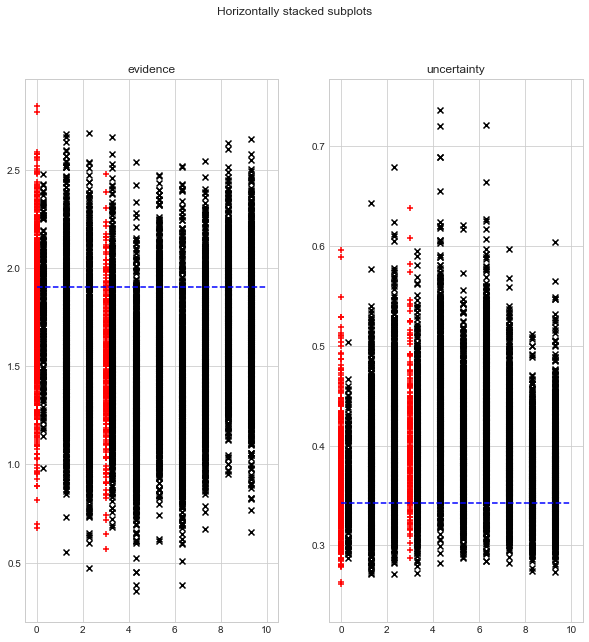

In [21]:
###keras KL activated model 47 epochs
Predictions = displayEvidence(model,test_ds)

In [22]:
Predictions.to_csv("predictions_notraining.csv")

10000
Entropy


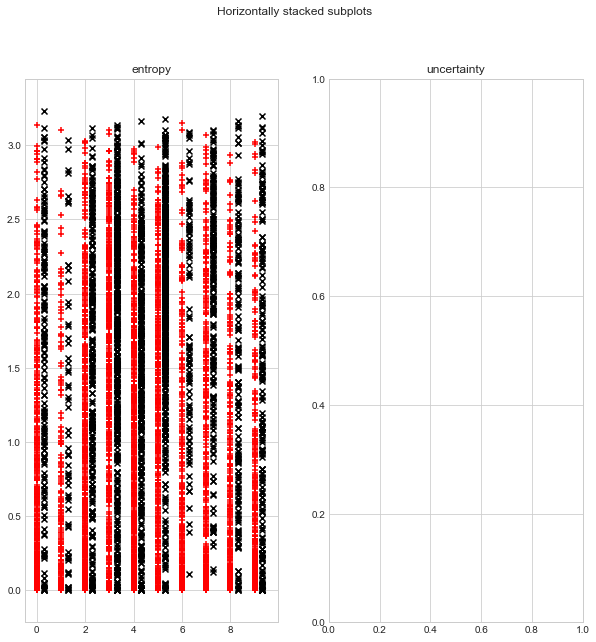

In [20]:
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #log(0) is evaulated as NAN and then clipped to approaching zero
        #rank is used to reduce multi-dim arrays but leave alone 1d arrays.
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies

    
def displayEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pEntropy = []
    pAcc=[]
    for i in range(len(test_ds)-1):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.predict(item[0])
#         print("accuracy:", x[1], "evidence:",x[2])
        
        pClass.append(tf.argmax(item[1],1).numpy()[0])
#         pEvidence.append(x[2])
        
        if np.argmax(x,1)[0]== np.argmax(item[1],1)[0]:
            pAcc.append(True)       
        else:
            pAcc.append(False)       
        pEntropy.append(calcEntropy_Tensors(x))
#         pUncertainty.append(x[3])   
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"label":pClass, "Acc":pAcc, "entropy":pEntropy})
    
# #     print(Predictions)
#     E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
#     E_threshold = E_threshold.iloc[0]
#     print("evidence Threshold >= correct: ", E_threshold)
#     U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
#     U_threshold = U_threshold.iloc[0]
#     print("uncertainty Threshold <= correct: ", U_threshold)

    print("Entropy")
#     print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
#     print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)
#     print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
#     print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

#     print("Evidence")
#     print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
#     print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
  
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['entropy'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['entropy'],c ='k',marker='x')
#     axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("entropy")

#     axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
#     axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
#     axs[1].plot(np.repeat(U_threshold,11),'b--')

    axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions

    ###keras KL activated model 47 epochs
Predictions = displayEntropy(model,test_ds)

In [21]:
def toVal(input):
    val = input.numpy()
    return val[0]
Predictions['entropy'] = Predictions['entropy'].map(toVal)
# print(Predictions.head())

In [ ]:


print(Predictions.groupby("Acc").count())
print(Predictions.groupby("Acc").mean())
print(Predictions.groupby("Acc").std())
E_threshold = Predictions.loc[(Predictions['Acc'] == True)].groupby("Acc")["entropy"].mean() + Predictions.loc[(Predictions['Acc'] == True)].groupby("Acc")["entropy"].std()
E_threshold = E_threshold.iloc[0]
print("Entropy Threshold >= correct: ", E_threshold)

print("Entropy")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] >= E_threshold)].sort_values("entropy").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] < E_threshold)].sort_values("entropy").shape)


    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]


E_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] >= E_threshold)].sort_values("entropy")
E_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] < E_threshold)].sort_values("entropy")

plt.suptitle('Horizontally stacked subplots')
plt.scatter(correct_rows['label'],correct_rows['entropy'],c ='r',marker='+')
plt.scatter(E_correct_rows_missed['label'],E_correct_rows_missed['entropy'],c ='g',marker='+')
plt.scatter(incorrect_rows['label']+.3,incorrect_rows['entropy'],c ='k',marker='x')
plt.scatter(E_incorrect_rows_accepted['label']+.3,E_incorrect_rows_accepted['entropy'],c ='b',marker='x')
plt.plot(np.repeat(E_threshold,11),'b--')
plt.legend(['Entropy Threshold','Correct Clasifications',"Rejected Correct Answers",'Incorrect Answers',"Accepted Incorrect Answers"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Entropy")


# plt.set_size_inches(10, 10)
plt.show()

          label  evidence  uncertainty
Acc                                   
0.000000   3632      3632         3632
0.641899      1         1            1
1.000000   6366      6366         6366
             label  evidence  uncertainty
Acc                                      
0.000000  4.158315  0.064194     0.954395
0.641899  8.000000  0.379165     0.820434
1.000000  4.694628  0.563281     0.741637
             label  evidence  uncertainty
Acc                                      
0.000000  2.575223  0.169370     0.094995
0.641899       NaN       NaN          NaN
1.000000  3.011900  0.698999     0.242058
evidence Threshold >= correct:  0.23356400851202824
uncertainty Threshold <= correct:  0.859399828015022
Uncertainty
Passed correct answers: (2918, 4)
Accepted incorrect answers (353, 4)
Evidence
Passed correct answers: (3194, 4)
Accepted incorrect answers (263, 4)


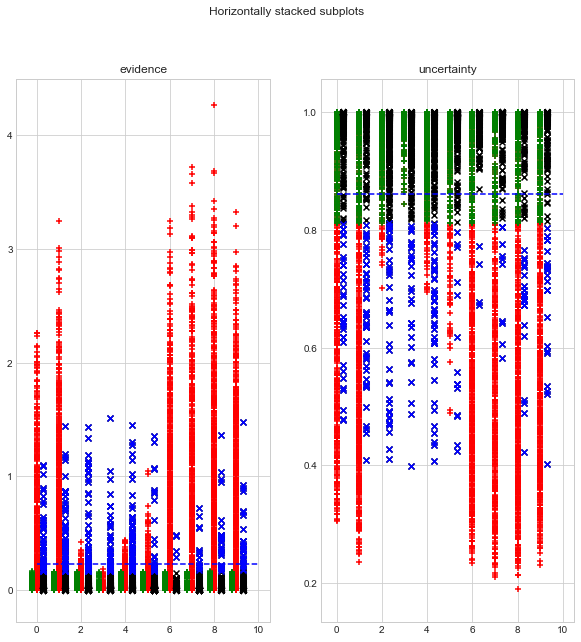

In [ ]:
print(Predictions.groupby("Acc").count())
print(Predictions.groupby("Acc").mean())
print(Predictions.groupby("Acc").std())
E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
E_threshold = E_threshold.iloc[0]
print("evidence Threshold >= correct: ", E_threshold)
U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
U_threshold = U_threshold.iloc[0]
print("uncertainty Threshold <= correct: ", U_threshold)

print("Uncertainty")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

print("Evidence")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)

fig, axs = plt.subplots(1, 2)
    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]


E_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence")
E_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence")


U_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty")
U_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty")

fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(U_correct_rows_missed['label']-.2,U_correct_rows_missed['evidence'],c ='g',marker='+')
axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].scatter(U_incorrect_rows_accepted['label']+.3,U_incorrect_rows_accepted['evidence'],c ='b',marker='x')
axs[0].plot(np.repeat(E_threshold,11),'b--')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(E_correct_rows_missed['label'],E_correct_rows_missed['uncertainty'],c ='g',marker='+')
axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].scatter(E_incorrect_rows_accepted['label']+.3,E_incorrect_rows_accepted['uncertainty'],c ='b',marker='x')
axs[1].plot(np.repeat(U_threshold,11),'b--')

axs[1].set_title("uncertainty")

fig.set_size_inches(10, 10)
plt.show()